# LHCO Cathode Generation Pipeline
After the particle level models and the jet feature models have been trained, the final step is to run the whole generation pipeline. This is the purpose of this notebook.

## Imports

In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity

2023-09-07 10:52:02.635065: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 10:52:02.696450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 10:52:03.751628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [5]:
data_folder = os.environ.get("DATA_DIR")

# Generate mjj samples
We fit a KDE to the mjj distribution of the signal and background samples. We then sample from the KDE to generate new mjj samples in the signal region.

In [11]:
n_samples = 200_000

In [12]:
path = f"{data_folder}/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(path, "r") as f:
    jets = f["jet_data"][:]

In [13]:
p4_jets = ef.p4s_from_ptyphims(jets)

In [14]:
sum_p4 = p4_jets[:, 0] + p4_jets[:, 1]
mjj = ef.ms_from_p4s(sum_p4)

In [15]:
args_to_keep = ((mjj < 3300) & (mjj > 2300)) | ((mjj > 3700) & (mjj < 5000))
args_to_keep_sr = (mjj > 3300) & (mjj < 3700)

In [16]:
mjj_sb = mjj[args_to_keep]
mjj_sr = mjj[args_to_keep_sr]
args_to_keep_sb_sr = args_to_keep | args_to_keep_sr
mjj_sb_sr = mjj[args_to_keep_sb_sr]

# Particle Feature Model

### Load Models

In [17]:
experiment = "/lhco/lhco_both_jets.yaml"

In [18]:
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment}"])
    # print(OmegaConf.to_yaml(cfg_x))

In [19]:
datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)

In [20]:
datamodule.setup()

### Load checkpoint

In [ ]:
ckpt = (
    "/beegfs/desy/user/ewencedr/deep-learning/logs/lhco all"
    " jets/runs/2023-08-25_14-42-49/checkpoints/last-EMA.ckpt"
)
model = model.load_from_checkpoint(ckpt)

### Generate Data

In [ ]:
cond_x = datamodule.jet_data_sr_raw[:, 0]
mask_x = datamodule.mask_sr_raw[:, 0]
cond_y = datamodule.jet_data_sr_raw[:, 1]
mask_y = datamodule.mask_sr_raw[:, 1]

In [ ]:
print(cond_x.shape)
print(mask_x.shape)
print(cond_y.shape)
print(mask_y.shape)

In [ ]:
normalized_cond_x = normalize_tensor(
    torch.Tensor(cond_x).clone(),
    datamodule.cond_means,
    datamodule.cond_stds,
    datamodule.hparams.normalize_sigma,
)

In [ ]:
normalized_cond_y = normalize_tensor(
    torch.Tensor(cond_y).clone(),
    datamodule.cond_means,
    datamodule.cond_stds,
    datamodule.hparams.normalize_sigma,
)

In [ ]:
torch.manual_seed(9999)
data_x, generation_time_x = generate_data(
    model,
    num_jet_samples=len(mask_x),
    batch_size=2048,
    cond=torch.Tensor(normalized_cond_x),
    variable_set_sizes=datamodule.hparams.variable_jet_sizes,
    mask=torch.Tensor(mask_x),
    normalized_data=datamodule.hparams.normalize,
    means=datamodule.means,
    stds=datamodule.stds,
    ode_solver="midpoint",
    ode_steps=100,
)

In [ ]:
path_x = f"{data_folder}/lhco/generated/x_data_datacond_both_jets.h5"

In [ ]:
print(mjj_sr.shape)

In [ ]:
# with h5py.File(path_x, "w") as f:
#    f.create_dataset("data", data=data_x)
#    f.create_dataset("generation_time", data=generation_time_x)
#    f.create_dataset("mask", data=mask_x)
#    f.create_dataset("cond", data=cond_x)
#    f.create_dataset("mjj", data=mjj_sr)

In [ ]:
with h5py.File(path_x, "r") as f:
    data_x = f["data"][:]

In [ ]:
torch.manual_seed(9999)
data_y, generation_time_y = generate_data(
    model,
    num_jet_samples=len(mask_y),
    batch_size=2048,
    cond=torch.Tensor(normalized_cond_y),
    variable_set_sizes=datamodule.hparams.variable_jet_sizes,
    mask=torch.Tensor(mask_y),
    normalized_data=datamodule.hparams.normalize,
    means=datamodule.means,
    stds=datamodule.stds,
    ode_solver="midpoint",
    ode_steps=100,
)

In [ ]:
path_y = f"{data_folder}/lhco/generated/y_data_datacond_both_jets.h5"

In [ ]:
# with h5py.File(path_y, "w") as f:
#    f.create_dataset("data", data=data_y)
#    f.create_dataset("generation_time", data=generation_time_y)
#    f.create_dataset("mask", data=mask_y)
#    f.create_dataset("cond", data=cond_y)
#    f.create_dataset("mjj", data=mjj_sr)

In [ ]:
with h5py.File(path_y, "r") as f:
    data_y = f["data"][:]

In [ ]:
print(data_y.shape)

In [ ]:
print(np.sum(data_x[:, :, 2] > 1))

In [ ]:
np.min(data_y[:, :, 2][data_y[:, :, 2] > 0.0])

remove unphysical values

In [ ]:
data_x[data_x[:, :, 2] < 0] = np.min(
    datamodule.tensor_train.numpy()[:, :, 2][datamodule.tensor_train.numpy()[:, :, 2] > 0.0]
)
data_x[data_x[:, :, 2] > 1] = np.max(
    datamodule.tensor_train.numpy()[:, :, 2][datamodule.tensor_train.numpy()[:, :, 2] < 1.0]
)

In [ ]:
data_y[data_y[:, :, 2] < 0] = np.min(
    datamodule.tensor_train.numpy()[:, :, 2][datamodule.tensor_train.numpy()[:, :, 2] > 0.0]
)
data_y[data_y[:, :, 2] > 1] = np.max(
    datamodule.tensor_train.numpy()[:, :, 2][datamodule.tensor_train.numpy()[:, :, 2] < 1.0]
)

In [ ]:
print(data_x.shape)
print(np.sum(data_x[:, :, 2] < 0))
print(np.sum(data_x[:, :, 2] > 1))

### Save generated data

### Plots

In [ ]:
background_data_x = datamodule.particle_data_sr_raw[:, 0]

In [ ]:
background_data_x = background_data_x[..., [1, 2, 0]]

In [ ]:
background_data_y = datamodule.particle_data_sr_raw[:, 1]

In [ ]:
background_data_y = background_data_y[..., [1, 2, 0]]

In [ ]:
print(data_x.shape)
print(background_data_x.shape)

In [ ]:
plot_config_x = {
    "num_samples": min(len(data_x), len(background_data_x)),
    "plot_jet_features": False,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
}
plot_prep_config_x = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
plot_config_y = {
    "num_samples": min(len(data_y), len(background_data_y)),
    "plot_jet_features": False,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
}
plot_prep_config_y = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_y.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
(
    jet_data_x,
    efps_values_x,
    pt_selected_particles_x,
    pt_selected_multiplicities_x,
) = prepare_data_for_plotting(
    np.array([data_x[: len(background_data_x)]]),
    **plot_prep_config_x,
)

In [ ]:
(
    jet_data_y,
    efps_values_y,
    pt_selected_particles_y,
    pt_selected_multiplicities_y,
) = prepare_data_for_plotting(
    np.array([data_y[: len(background_data_y)]]),
    **plot_prep_config_y,
)

In [ ]:
(
    jet_data_sim_x,
    efps_sim_x,
    pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim_x,
) = prepare_data_for_plotting(
    [background_data_x],
    **plot_prep_config_x,
)
jet_data_sim_x, efps_sim_x, pt_selected_particles_sim_x = (
    jet_data_sim_x[0],
    efps_sim_x[0],
    pt_selected_particles_sim_x[0],
)

In [ ]:
(
    jet_data_sim_y,
    efps_sim_y,
    pt_selected_particles_sim_y,
    pt_selected_multiplicities_sim_y,
) = prepare_data_for_plotting(
    [background_data_y],
    **plot_prep_config_y,
)
jet_data_sim_y, efps_sim_y, pt_selected_particles_sim_y = (
    jet_data_sim_y[0],
    efps_sim_y[0],
    pt_selected_particles_sim_y[0],
)

In [ ]:
print(efps_sim_x.shape)
print(np.concatenate(efps_sim_x).shape)

In [ ]:
fig_x = plot_data(
    particle_data=np.array([data_x[: len(background_data_x)]]),
    sim_data=background_data_x,
    jet_data_sim=jet_data_sim_x,
    jet_data=jet_data_x,
    efps_sim=efps_sim_x,
    efps_values=efps_values_x,
    pt_selected_particles=pt_selected_particles_x,
    pt_selected_multiplicities=pt_selected_multiplicities_x,
    pt_selected_particles_sim=pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x,
    **plot_config_x,
)

In [ ]:
fig_y = plot_data(
    particle_data=np.array([data_y[: len(background_data_y)]]),
    sim_data=background_data_y,
    jet_data_sim=jet_data_sim_y,
    jet_data=jet_data_y,
    efps_sim=efps_sim_y,
    efps_values=efps_values_y,
    pt_selected_particles=pt_selected_particles_y,
    pt_selected_multiplicities=pt_selected_multiplicities_y,
    pt_selected_particles_sim=pt_selected_particles_sim_y,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_y,
    **plot_config_y,
)

### Back to non-rel. Coordinates

conditioning from feature model to recalculate the nonrel coordinates of the generated particles

In [ ]:
print(datamodule.cond_means)

In [ ]:
pt_x = cond_x[:, 0].reshape(-1, 1)
eta_x = cond_x[:, 1].reshape(-1, 1)
phi_x = cond_x[:, 2].reshape(-1, 1)
m_x = cond_x[:, 3].reshape(-1, 1)

In [ ]:
pt_y = cond_y[:, 0].reshape(-1, 1)
eta_y = cond_y[:, 1].reshape(-1, 1)
phi_y = cond_y[:, 2].reshape(-1, 1)
m_y = cond_y[:, 3].reshape(-1, 1)

In [ ]:
print(eta_x.shape)

In [ ]:
mask_x_nonrel = np.expand_dims((data_x[..., 2] > 0).astype(int), axis=-1)
non_rel_eta_x = np.expand_dims(data_x.copy()[:, :, 0] + eta_x, axis=-1)
non_rel_phi_x = np.expand_dims(data_x.copy()[:, :, 1] + phi_x, axis=-1)
# wrap phi between -pi and pi
non_rel_phi_x = np.where(
    non_rel_phi_x > np.pi,
    non_rel_phi_x - 2 * np.pi,
    non_rel_phi_x,
)
non_rel_phi_x = np.where(
    non_rel_phi_x < -np.pi,
    non_rel_phi_x + 2 * np.pi,
    non_rel_phi_x,
)
non_rel_pt_x = np.expand_dims(data_x.copy()[:, :, 2] * pt_x, axis=-1)
# fix the masking
non_rel_eta_x = non_rel_eta_x * mask_x_nonrel
non_rel_phi_x = non_rel_phi_x * mask_x_nonrel
data_x_nonrel = np.concatenate([non_rel_eta_x, non_rel_phi_x, non_rel_pt_x], axis=-1)

In [ ]:
mask_y_nonrel = np.expand_dims((data_y[..., 2] > 0).astype(int), axis=-1)
non_rel_eta_y = np.expand_dims(data_y.copy()[:, :, 0] + eta_y, axis=-1)
non_rel_phi_y = np.expand_dims(data_y.copy()[:, :, 1] + phi_y, axis=-1)
# wrap phi between -pi and pi
non_rel_phi_y = np.where(
    non_rel_phi_y > np.pi,
    non_rel_phi_y - 2 * np.pi,
    non_rel_phi_y,
)
non_rel_phi_y = np.where(
    non_rel_phi_y < -np.pi,
    non_rel_phi_y + 2 * np.pi,
    non_rel_phi_y,
)
non_rel_pt_y = np.expand_dims(data_y.copy()[:, :, 2] * pt_y, axis=-1)
# fix the masking
non_rel_eta_y = non_rel_eta_y * mask_y_nonrel
non_rel_phi_y = non_rel_phi_y * mask_y_nonrel
data_y_nonrel = np.concatenate([non_rel_eta_y, non_rel_phi_y, non_rel_pt_y], axis=-1)

load non rel. data and select the same events that were generated

In [ ]:
path_nonrel = f"{data_folder}/lhco/final_data/processed_data_background.h5"
with h5py.File(path_nonrel, "r") as f:
    particle_data_nonrel = f["constituents"][:]

In [ ]:
particle_data_nonrel_sr = particle_data_nonrel[args_to_keep_sr]

In [ ]:
background_data_x_nonrel = particle_data_nonrel_sr[
    :, 0
]  # particle_data_nonrel_sr_test[: len(data_x_nonrel), 0]
background_data_x_nonrel = background_data_x_nonrel[:, :, [1, 2, 0]]

In [ ]:
background_data_y_nonrel = particle_data_nonrel_sr[
    :, 1
]  # particle_data_nonrel_sr_test[: len(data_y_nonrel), 1]
background_data_y_nonrel = background_data_y_nonrel[:, :, [1, 2, 0]]

In [ ]:
plot_config_x_nonrel = {
    "num_samples": -1,
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 3, 10],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 25,
    "close_fig": False,
    "mass_linear": True,
    "plot_xlabels": [
        r"Particle $p_\mathrm{T}$",
        r"Particle $\eta$",
        r"Particle $\phi$",
        r"Jet $p_\mathrm{T}$",
    ],
}
plot_prep_config_x_nonrel = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x_nonrel.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
plot_config_y_nonrel = {
    "num_samples": -1,
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 3, 10],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 25,
    "close_fig": False,
    "mass_linear": True,
    "plot_xlabels": [
        r"Particle $p_\mathrm{T}$",
        r"Particle $\eta$",
        r"Particle $\phi$",
        r"Jet $p_\mathrm{T}$",
    ],
}
plot_prep_config_y_nonrel = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_y_nonrel.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
(
    jet_data_x_nonrel,
    efps_values_x_nonrel,
    pt_selected_particles_x_nonrel,
    pt_selected_multiplicities_x_nonrel,
) = prepare_data_for_plotting(
    np.array([data_x_nonrel[: len(background_data_x_nonrel)]]),
    **plot_prep_config_x_nonrel,
)

In [ ]:
(
    jet_data_y_nonrel,
    efps_values_y_nonrel,
    pt_selected_particles_y_nonrel,
    pt_selected_multiplicities_y_nonrel,
) = prepare_data_for_plotting(
    np.array([data_y_nonrel[: len(background_data_y_nonrel)]]),
    **plot_prep_config_y_nonrel,
)

In [ ]:
(
    jet_data_sim_x_nonrel,
    efps_sim_x_nonrel,
    pt_selected_particles_sim_x_nonrel,
    pt_selected_multiplicities_sim_x_nonrel,
) = prepare_data_for_plotting(
    [background_data_x_nonrel],
    **plot_prep_config_x_nonrel,
)
jet_data_sim_x_nonrel, efps_sim_x_nonrel, pt_selected_particles_sim_x_nonrel = (
    jet_data_sim_x_nonrel[0],
    efps_sim_x_nonrel[0],
    pt_selected_particles_sim_x_nonrel[0],
)

In [ ]:
(
    jet_data_sim_y_nonrel,
    efps_sim_y_nonrel,
    pt_selected_particles_sim_y_nonrel,
    pt_selected_multiplicities_sim_y_nonrel,
) = prepare_data_for_plotting(
    [background_data_y_nonrel],
    **plot_prep_config_y_nonrel,
)
jet_data_sim_y_nonrel, efps_sim_y_nonrel, pt_selected_particles_sim_y_nonrel = (
    jet_data_sim_y_nonrel[0],
    efps_sim_y_nonrel[0],
    pt_selected_particles_sim_y_nonrel[0],
)

In [ ]:
fig_x_nonrel = plot_data(
    particle_data=np.array([data_x_nonrel[: len(background_data_x_nonrel)]]),
    sim_data=background_data_x_nonrel,
    jet_data_sim=jet_data_sim_x_nonrel,
    jet_data=jet_data_x_nonrel,
    efps_sim=efps_sim_x_nonrel,
    efps_values=efps_values_x_nonrel,
    pt_selected_particles=pt_selected_particles_x_nonrel,
    pt_selected_multiplicities=pt_selected_multiplicities_x_nonrel,
    pt_selected_particles_sim=pt_selected_particles_sim_x_nonrel,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x_nonrel,
    **plot_config_x_nonrel,
)

In [ ]:
fig_y_nonrel = plot_data(
    particle_data=np.array([data_y_nonrel[: len(background_data_y_nonrel)]]),
    sim_data=background_data_y_nonrel,
    jet_data_sim=jet_data_sim_y_nonrel,
    jet_data=jet_data_y_nonrel,
    efps_sim=efps_sim_y_nonrel,
    efps_values=efps_values_y_nonrel,
    pt_selected_particles=pt_selected_particles_y_nonrel,
    pt_selected_multiplicities=pt_selected_multiplicities_y_nonrel,
    pt_selected_particles_sim=pt_selected_particles_sim_y_nonrel,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_y_nonrel,
    **plot_config_y_nonrel,
)

## Deeper Evaluation

In [ ]:
path_final_all = ""

In [ ]:
with h5py.File(path_final_all, "r") as f:
    data_x = f["particle_data_rel_x"][:][..., [1, 2, 0]]
    data_y = f["particle_data_rel_y"][:][..., [1, 2, 0]]
    data_x_nonrel = f["particle_data_nonrel_x"][:][..., [1, 2, 0]]
    data_y_nonrel = f["particle_data_nonrel_y"][:][..., [1, 2, 0]]
    cond_x_file = f["jet_features_x"][:]
    cond_y_file = f["jet_features_y"][:]
    mjj_sr = f["mjj"][:]

In [ ]:
print(jet_data_sim_x_nonrel.shape)
print(jet_data_x_nonrel.shape)

In [ ]:
diff_sim = abs(jet_data_sim_x_nonrel - jet_data_sim_y_nonrel)
diff = abs(jet_data_x_nonrel[0] - jet_data_y_nonrel[0])

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
labels = [r"Diff Jet $p_\mathrm{T}$", r"Diff Jet $\eta$", r"Diff Jet $\phi$", r"Diff Jet $m$"]
for i, ax in enumerate(axs):
    hist = ax.hist(diff_sim[:, i], bins=100, alpha=0.5, label="sim", histtype="stepfilled")
    ax.hist(diff[:, i], bins=hist[1], label="gen.", histtype="step")
    ax.set_xlabel(labels[i])
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(cond_x.shape)

In [ ]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [ ]:
plt.hist(data_x[:, :, 2].flatten(), bins=100)
plt.yscale("log")
plt.show()

In [ ]:
jet_x_calc = get_jet_data(data_x_nonrel[..., [2, 0, 1]])
jet_y_calc = get_jet_data(data_y_nonrel[..., [2, 0, 1]])
print(jet_x_calc.shape)
p4_jets_x_calc = ef.p4s_from_ptyphims(jet_x_calc)
p4_jets_y_calc = ef.p4s_from_ptyphims(jet_y_calc)
sum_p4_calc = p4_jets_x_calc + p4_jets_y_calc
mjj_calc = ef.ms_from_p4s(sum_p4_calc)

In [ ]:
hist = plt.hist(cond_x[:, 3], bins=100, alpha=0.5, label="cond")
plt.hist(jet_x_calc[:, 3], bins=hist[1], histtype="step")
plt.show()

In [ ]:
p4_jets_x = ef.p4s_from_ptyphims(cond_x)
p4_jets_y = ef.p4s_from_ptyphims(cond_y)
sum_p4 = p4_jets_x + p4_jets_y
mjj = ef.ms_from_p4s(sum_p4)

In [ ]:
print(mjj_sr.shape)
print(mjj_calc.shape)

In [ ]:
hist = plt.hist(mjj_calc, bins=100, alpha=0.5, label="generated", histtype="stepfilled")
plt.hist(mjj_sr, bins=hist[1], histtype="step", label="true")
plt.legend()
plt.yscale("log")
plt.xlabel(r"$m_{jj}$")
plt.show()

# Save generated data to file

In [ ]:
path_final_all = f"{data_folder}/lhco/generated/final_data_all_datacond_both_jets_v2.h5"

In [ ]:
print(mask_x.shape)
sum_mask_x = np.sum(mask_x, axis=-2)
print(np.count_nonzero(mask_x[0]))
print(sum_mask_x.shape)
print(np.sum(sum_mask_x[0]))

In [ ]:
print(mask_y.shape)
sum_mask_y = np.sum(mask_y, axis=-2)
print(np.count_nonzero(mask_y[0]))
print(sum_mask_y.shape)
print(np.sum(sum_mask_y[0]))

In [ ]:
# add particle multiplicity to cond
cond_x_file = np.concatenate([cond_x, sum_mask_x], axis=-1)
cond_y_file = np.concatenate([cond_y, sum_mask_y], axis=-1)

In [ ]:
print(data_x.shape)
print(data_y.shape)
print(data_x_nonrel.shape)
print(data_y_nonrel.shape)
# print(data_jet_feature[:, :5].shape)
# print(data_jet_feature[:, 5:].shape)
print(cond_x_file.shape)
print(cond_y_file.shape)
print(mjj_sr.shape)

In [ ]:
plt.hist(cond_x_file[..., -1], bins=100, histtype="step", label="x")
plt.hist(cond_y_file[..., -1], bins=100, histtype="step", label="y")
plt.legend()
plt.show()

In [ ]:
# with h5py.File(path_final_all, "w") as f:
#    f.create_dataset("particle_data_rel_x", data=data_x[:, :, [2, 0, 1]])
#    f.create_dataset("particle_data_rel_y", data=data_y[:, :, [2, 0, 1]])
#    f.create_dataset("particle_data_nonrel_x", data=data_x_nonrel[:, :, [2, 0, 1]])
#    f.create_dataset("particle_data_nonrel_y", data=data_y_nonrel[:, :, [2, 0, 1]])
#    f.create_dataset("jet_features_x", data=cond_x_file)
#    f.create_dataset("jet_features_y", data=cond_y_file)
#    f.create_dataset("mjj", data=mjj_sr)

## combine both jets

In [ ]:
data_x_nonrel_ptetaphi = data_x_nonrel[:, :, [2, 0, 1]]
data_y_nonrel_ptetaphi = data_x_nonrel[:, :, [2, 0, 1]]

In [ ]:
data_combined = np.concatenate((data_x_nonrel_ptetaphi, data_y_nonrel_ptetaphi), axis=1)
print(data_combined.shape)

In [ ]:
padded_data = np.pad(
    data_combined,
    ((0, 0), (0, 700 - data_combined.shape[1]), (0, 0)),
    "constant",
    constant_values=0,
)
print(padded_data.shape)

In [ ]:
final_data = np.reshape(padded_data, (padded_data.shape[0], -1))
print(final_data.shape)

In [ ]:
import pandas as pd

In [ ]:
final_path = f"{data_folder}/lhco/generated/final_data.h5"
df_final = pd.DataFrame(data=final_data)
df_final.to_hdf(final_path, key="df", mode="w")

In [ ]:
filepath = f"{data_folder}/lhco/events_anomalydetection_v2.h5"

In [ ]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:", sum(df.memory_usage(deep=True)) / (1024**3))

# Evaluation

In [ ]:
with h5py.File(path_final_all, "r") as f:
    eval_x_rel = f["particle_data_rel_x"][:]
    eval_y_rel = f["particle_data_rel_y"][:]
    eval_x_nonrel = f["particle_data_nonrel_x"][:]
    eval_y_nonrel = f["particle_data_nonrel_y"][:]
    eval_jet_features_x = f["jet_features_x"][:]
    eval_jet_features_y = f["jet_features_y"][:]
    eval_mjj = f["mjj"][:]

In [ ]:
print(eval_x_rel.shape)
print()

In [ ]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [ ]:
eval_x_rel = eval_x_rel[:, :, [2, 0, 1]]
eval_y_rel = eval_y_rel[:, :, [2, 0, 1]]
eval_x_nonrel = eval_x_nonrel[:, :, [2, 0, 1]]
eval_y_nonrel = eval_y_nonrel[:, :, [2, 0, 1]]
print(eval_x_rel.shape)

In [ ]:
eval_jet_data_x = get_jet_data(eval_x_rel)
eval_jet_data_y = get_jet_data(eval_y_rel)
eval_jet_data_x_nonrel = get_jet_data(eval_x_nonrel)
eval_jet_data_y_nonrel = get_jet_data(eval_y_nonrel)

In [ ]:
print(eval_jet_data_x[:, -1].shape)
print(eval_jet_features_x[:, -1].shape)

In [ ]:
datamodule_x = None

In [ ]:
datamodule_x.cond_means.shape

In [ ]:
# normalize conditioning variables
eval_normalized_cond_x = normalize_tensor(
    torch.tensor(eval_jet_features_x[:, :4], dtype=torch.float32).clone(),
    datamodule_x.cond_means,
    datamodule_x.cond_stds,
    datamodule_x.hparams.normalize_sigma,
).numpy()

In [ ]:
eval_normalized_cond_x.shape

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_normalized_cond_x[:, i]), np.max(eval_normalized_cond_x[:, i]))
    min_v = min(np.min(eval_normalized_cond_x[:, i]), np.min(eval_normalized_cond_x[:, i]))

    ax.hist2d(
        eval_normalized_cond_x[:, i],
        eval_jet_data_x[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("higher mass jet rel")
plt.tight_layout()
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_x[:, -2]), np.max(eval_jet_features_x[:, -2]))
min_v = min(np.min(eval_jet_features_x[:, -2]), np.min(eval_jet_features_x[:, -2]))

plt.hist2d(
    eval_jet_features_x[:, -2],
    eval_jet_features_x[:, -2],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("ref.")
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_x[:, -2]), np.max(eval_jet_features_x[:, -2]))
min_v = min(np.min(eval_jet_features_x[:, -2]), np.min(eval_jet_features_x[:, -2]))

plt.hist2d(
    eval_jet_features_x[:, -2],
    eval_jet_data_x[:, -1],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("rel.")
plt.plot()

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_jet_features_x[:, i]), np.max(eval_jet_features_x[:, i]))
    min_v = min(np.min(eval_jet_features_x[:, i]), np.min(eval_jet_features_x[:, i]))

    ax.hist2d(
        eval_jet_features_x[:, i],
        eval_jet_data_x_nonrel[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("higher mass jet")
plt.tight_layout()
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_y[:, -2]), np.max(eval_jet_features_y[:, -2]))
min_v = min(np.min(eval_jet_features_y[:, -2]), np.min(eval_jet_features_y[:, -2]))

plt.hist2d(
    eval_jet_features_y[:, -2],
    eval_jet_features_y[:, -2],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("ref. y")
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_y[:, -2]), np.max(eval_jet_features_y[:, -2]))
min_v = min(np.min(eval_jet_features_y[:, -2]), np.min(eval_jet_features_y[:, -2]))

plt.hist2d(
    eval_jet_features_y[:, -2],
    eval_jet_data_y[:, -1],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("rel.")
plt.plot()

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_jet_features_y[:, i]), np.max(eval_jet_features_y[:, i]))
    min_v = min(np.min(eval_jet_features_y[:, i]), np.min(eval_jet_features_y[:, i]))

    ax.hist2d(
        eval_jet_features_y[:, i],
        eval_jet_data_y_nonrel[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("lighter mass jet")
plt.tight_layout()
plt.plot()

# Reorder data

In [19]:
path_final_all = f"{data_folder}/lhco/generated/final_data_all_datacond_both_jets_v2.h5"

In [20]:
with h5py.File(path_final_all, "r") as f:
    eval_x_rel = f["particle_data_rel_x"][:]
    eval_y_rel = f["particle_data_rel_y"][:]
    eval_x_nonrel = f["particle_data_nonrel_x"][:]
    eval_y_nonrel = f["particle_data_nonrel_y"][:]
    eval_jet_features_x = f["jet_features_x"][:]
    eval_jet_features_y = f["jet_features_y"][:]
    eval_mjj = f["mjj"][:]

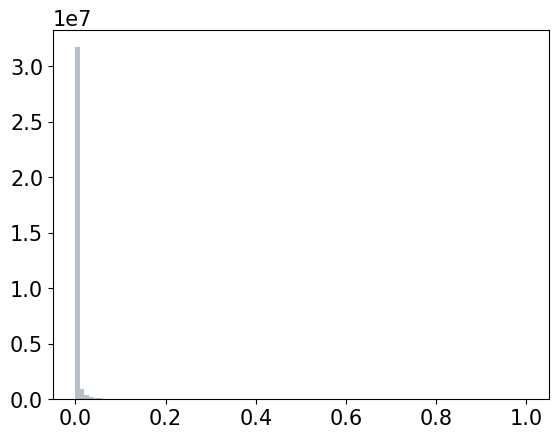

In [21]:
plt.hist(eval_x_rel[:, :, 0].flatten(), bins=100)
plt.show()

In [22]:
print(eval_x_rel.shape)
print(eval_y_rel.shape)

(121351, 279, 3)
(121351, 279, 3)


In [23]:
stack_jet = np.stack([eval_jet_features_x, eval_jet_features_y], axis=1)
print(stack_jet.shape)

(121351, 2, 5)


In [24]:
print(stack_jet[0, 0, :])
print(stack_jet[0, 1, :])

[ 1.55725584e+03 -2.82926726e-01 -4.48003080e-01  2.37894066e+02
  2.90000000e+01]
[1.58957248e+03 3.16145142e-01 2.74671447e+00 3.88960308e+01
 1.40000000e+01]


In [29]:
pt = stack_jet[:, :, 0]
print(pt.shape)
args = np.argsort(pt, axis=1)[:,::-1]
perm = np.random.permutation(args.shape[0])
args = args[perm]
print(args.shape)
pt_sorted = np.take_along_axis(pt, args, axis=1)
print(pt_sorted.shape)
print(pt_sorted[0, 0])
print(pt_sorted[0, 1])

(121351, 2)
(121351, 2)
(121351, 2)
1589.5724773554919
1557.2558440605264


In [30]:
pt_sorted_jets = np.take_along_axis(stack_jet, args[...,None], axis=1)
print(pt_sorted_jets.shape)
print(pt_sorted_jets[0, 0, :])
print(pt_sorted_jets[0, 1, :])

(121351, 2, 5)
[1.58957248e+03 3.16145142e-01 2.74671447e+00 3.88960308e+01
 1.40000000e+01]
[ 1.55725584e+03 -2.82926726e-01 -4.48003080e-01  2.37894066e+02
  2.90000000e+01]


In [31]:
stack = np.stack([eval_x_rel, eval_y_rel], axis=1)
print(stack.shape)

(121351, 2, 279, 3)


In [32]:
stack_nonrel = np.stack([eval_x_nonrel, eval_y_nonrel], axis=1)

In [33]:
print(stack[0,0,:10,0])
print(stack[0,1,:10,0])

[0.01134892 0.00093895 0.00058987 0.00149619 0.00200351 0.46292546
 0.00314725 0.00083771 0.06343304 0.00247614]
[0.10970239 0.00206823 0.00088487 0.00222742 0.00380306 0.7026862
 0.02775466 0.00115536 0.12109394 0.02618369]


In [34]:
stack_sorted = np.take_along_axis(stack, args[...,None,None], axis=1)
stack_sorted_nonrel = np.take_along_axis(stack_nonrel, args[...,None,None], axis=1)
print(stack_sorted.shape)
print(stack_sorted[0,0,:10,0])
print(stack_sorted[0,1,:10,0])

(121351, 2, 279, 3)
[0.10970239 0.00206823 0.00088487 0.00222742 0.00380306 0.7026862
 0.02775466 0.00115536 0.12109394 0.02618369]
[0.01134892 0.00093895 0.00058987 0.00149619 0.00200351 0.46292546
 0.00314725 0.00083771 0.06343304 0.00247614]


In [35]:
path_final_all_pt = f"{data_folder}/lhco/generated/final_data_all_datacond_both_jets_pts.h5"

In [36]:
print(pt_sorted_jets.shape)

(121351, 2, 5)


In [37]:
with h5py.File(path_final_all_pt, "w") as f:
    f.create_dataset("particle_data_rel_x", data=stack_sorted[:,0])
    f.create_dataset("particle_data_rel_y", data=stack_sorted[:,1])
    f.create_dataset("particle_data_nonrel_x", data=stack_sorted_nonrel[:,0])
    f.create_dataset("particle_data_nonrel_y", data=stack_sorted_nonrel[:,1])
    f.create_dataset("jet_features_x", data=pt_sorted_jets[:,0, :4])
    f.create_dataset("jet_features_y", data=pt_sorted_jets[:,1, :4])
    f.create_dataset("mjj", data=eval_mjj)

# save idealized data

In [66]:
path = f"{data_folder}/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(path, "r") as f:
    jets = f["jet_data"][:]
    particle_data = f["constituents"][:]

In [67]:
print(particle_data.shape)

(1000000, 2, 279, 3)


In [68]:
print(jets.shape)

(1000000, 2, 4)


In [69]:
p4_jets = ef.p4s_from_ptyphims(jets)
sum_p4 = p4_jets[:, 0] + p4_jets[:, 1]
mjj = ef.ms_from_p4s(sum_p4)
args_to_keep_sr = (mjj > 3300) & (mjj < 3700)
mjj_sr = mjj[args_to_keep_sr]
jets_sr = jets[args_to_keep_sr]
particle_data_sr = particle_data[args_to_keep_sr]
print(mjj_sr.shape)
print(jets_sr.shape)
print(particle_data_sr.shape)

(121351,)
(121351, 2, 4)
(121351, 2, 279, 3)


In [70]:
mask = particle_data_sr[...,0] != 0
print(mask.shape)
print(np.count_nonzero(particle_data_sr[0,1,:,0]))
particle_multiplicity = np.sum(mask, axis=-1)
print(particle_multiplicity.shape)
print(particle_multiplicity[0])
jet_features_sr = np.concatenate([jets_sr, particle_multiplicity[...,None]], axis=-1)
print(jet_features_sr.shape)

(121351, 2, 279)
29
(121351, 2)
[14 29]
(121351, 2, 5)


In [71]:
pt = jet_features_sr[:, :, 0]
print(pt.shape)
args = np.argsort(pt, axis=1)[:,::-1]
perm = np.random.permutation(args.shape[0])
args = args[perm]
print(args.shape)
pt_sorted = np.take_along_axis(pt, args, axis=1)
print(pt_sorted.shape)
print(pt_sorted[0, 0])
print(pt_sorted[0, 1])

(121351, 2)
(121351, 2)
(121351, 2)
1589.5724773554919
1557.2558440605264


In [72]:
sorted_jets = np.take_along_axis(jet_features_sr, args[...,None], axis=1)
sorted_consts = np.take_along_axis(particle_data_sr, args[...,None,None], axis=1)

In [73]:
print(sorted_jets.shape)
print(sorted_consts.shape)

(121351, 2, 5)
(121351, 2, 279, 3)


In [74]:
path_final_all_pt_id = f"{data_folder}/lhco/generated/idealized_LHCO.h5"

In [75]:
with h5py.File(path_final_all_pt_id, "w") as f:
    f.create_dataset("particle_features", data=sorted_consts)
    f.create_dataset("jet_features", data=sorted_jets)
    f.create_dataset("mjj", data=mjj_sr)
#with h5py.File(path_final_all_pt_id, "w") as f:
#    f.create_dataset("particle_data_rel_x", data=particle_data_sr[:,0])
#    f.create_dataset("particle_data_rel_y", data=particle_data_sr[:,1])
#    f.create_dataset("jet_features_x", data=jets_sr[:,0, :4])
#    f.create_dataset("jet_features_y", data=jets_sr[:,1, :4])
#    f.create_dataset("mjj", data=mjj_sr)

# compare to vinicius data

In [91]:
def get_mjj(jet_data: np.ndarray) -> np.ndarray:
    p4_jets = ef.p4s_from_ptyphims(jet_data)
    sum_p4 = p4_jets[:, 0] + p4_jets[:, 1]
    mjj = ef.ms_from_p4s(sum_p4)
    return mjj
#args_to_keep_sr = (mjj > 3300) & (mjj < 3700)
#mjj_sr = mjj[args_to_keep_sr]
#jets_sr = jets[args_to_keep_sr]
#particle_data_sr = particle_data[args_to_keep_sr]
    

In [92]:
background_path_rel = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(background_path_rel, "r") as f:
    jets_bckg_out = f["jet_data"][:]
    particle_data_bckg_out = f["constituents"][:]
    mask_bckg = f["mask"][:]

In [93]:
mjj_bckg = get_mjj(jets_bckg_out)
args_to_keep_sr = (mjj_bckg > 3300) & (mjj_bckg < 3700)
particle_data_bckg = particle_data_bckg_out[args_to_keep_sr]
jets_bckg_temp = jets_bckg_out[args_to_keep_sr]
print(particle_data_bckg.shape)
print(jets_bckg_temp.shape)
mask_bckg = particle_data_bckg[...,0] != 0
particle_multiplicity_bckg = np.sum(mask_bckg, axis=-1)
jets_bckg = np.concatenate([jets_bckg_temp, particle_multiplicity_bckg[...,None]], axis=-1)
print(jets_bckg.shape)

(121351, 2, 279, 3)
(121351, 2, 4)
(121351, 2, 5)


In [94]:
#path_v = f"{data_folder}/lhco/generated/FPCD_LHCO_SR.h5"
path_v = f"{data_folder}/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_v, "r") as f:
    print(f.keys())
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]
print(jet_features_v.shape)
print(particle_data_v.shape)
print(mjj_v.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(121351, 2, 5)
(121351, 2, 279, 3)
(121351,)


In [95]:
path_final_all_pt_id = f"{data_folder}/lhco/generated/final_data_all_datacond_both_jets_pts.h5"

In [96]:
with h5py.File(path_final_all_pt_id, "r") as f:
    particle_data_rel_x = f["particle_data_rel_x"][:]
    particle_data_rel_y = f["particle_data_rel_y"][:]
    jet_features_x = f["jet_features_x"][:]
    jet_features_y = f["jet_features_y"][:]
    mjj_c = f["mjj"][:]
jet_features_c = np.stack([jet_features_x, jet_features_y], axis=1)
particle_data_c = np.stack([particle_data_rel_x, particle_data_rel_y], axis=1)
print(jet_features_c.shape)
print(particle_data_c.shape)
print(mjj_c.shape)

(121351, 2, 4)
(121351, 2, 279, 3)
(121351,)


In [97]:
mask = particle_data_c[...,0] != 0
print(mask.shape)
print(np.count_nonzero(particle_data_c[0,1,:,0]))
particle_multiplicity = np.sum(mask, axis=-1)
print(particle_multiplicity.shape)
print(particle_multiplicity[0])
jet_features_c = np.concatenate([jet_features_c, particle_multiplicity[...,None]], axis=-1)
print(jet_features_c.shape)

(121351, 2, 279)
29
(121351, 2)
[14 29]
(121351, 2, 5)


In [98]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    mask = consts[...,0] != 0
    particle_multiplicity = np.sum(mask, axis=-1)
    full_jet_data = np.concatenate([jet_data, particle_multiplicity[...,None]], axis=-1)
    return full_jet_data

In [99]:
jet_features_v_calc = get_jet_data(particle_data_v)
print(jet_features_v_calc.shape)

(121351, 2, 5)


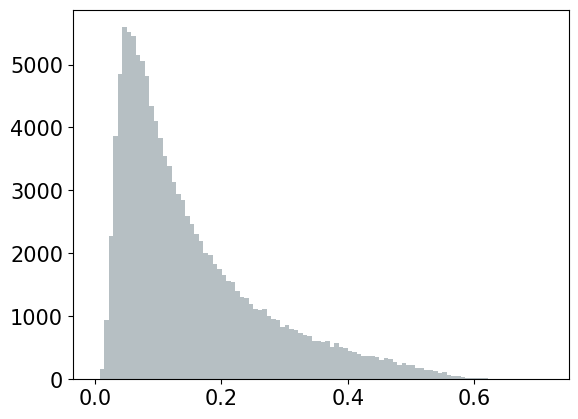

In [82]:
plt.hist(jet_features_v_calc[:,0,3], bins=100)
plt.show()

In [85]:
# make v data same size as c data
jet_features_v = jet_features_v[:len(jet_features_c)]
particle_data_v = particle_data_v[:len(particle_data_c)]
mjj_v = mjj_v[:len(mjj_c)]

In [86]:
print(jets_bckg.shape)
print(jet_features_v.shape)

(121351, 2, 5)
(121351, 2, 5)


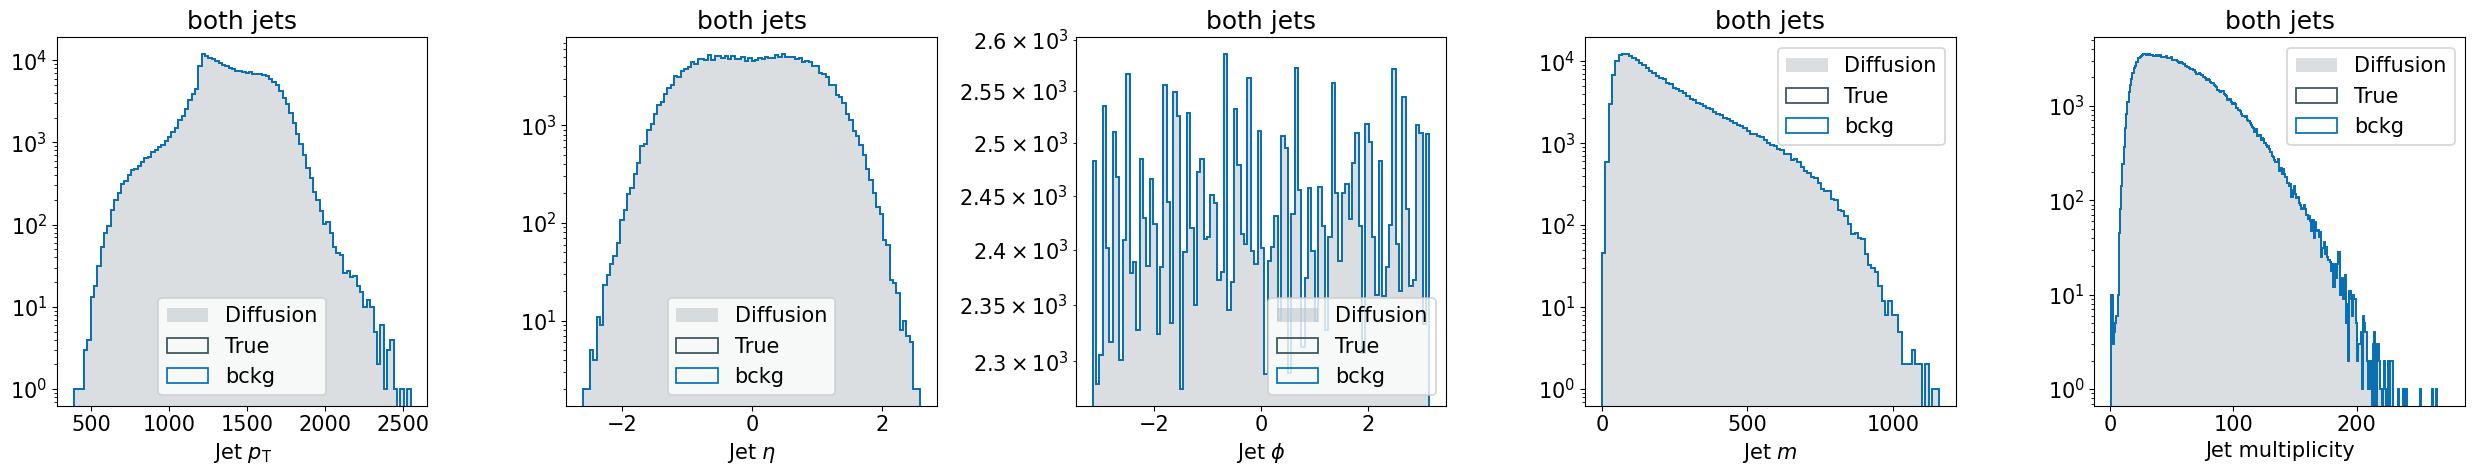

In [87]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_v[:,:, i])), int(np.max(jet_features_v[:,:, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_v[:,:, i].flatten(), bins=bins, alpha=0.5, label="Diffusion", histtype="stepfilled")
    #ax.hist(jet_features_c[:,:, i].flatten(), bins=hist[1], label="True", histtype="step")
    #ax.hist(jets_bckg[:,:, i].flatten(), bins=hist[1], label="bckg", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("both jets")
    ax.legend()
    ax.set_yscale("log")
plt.tight_layout()
plt.show()

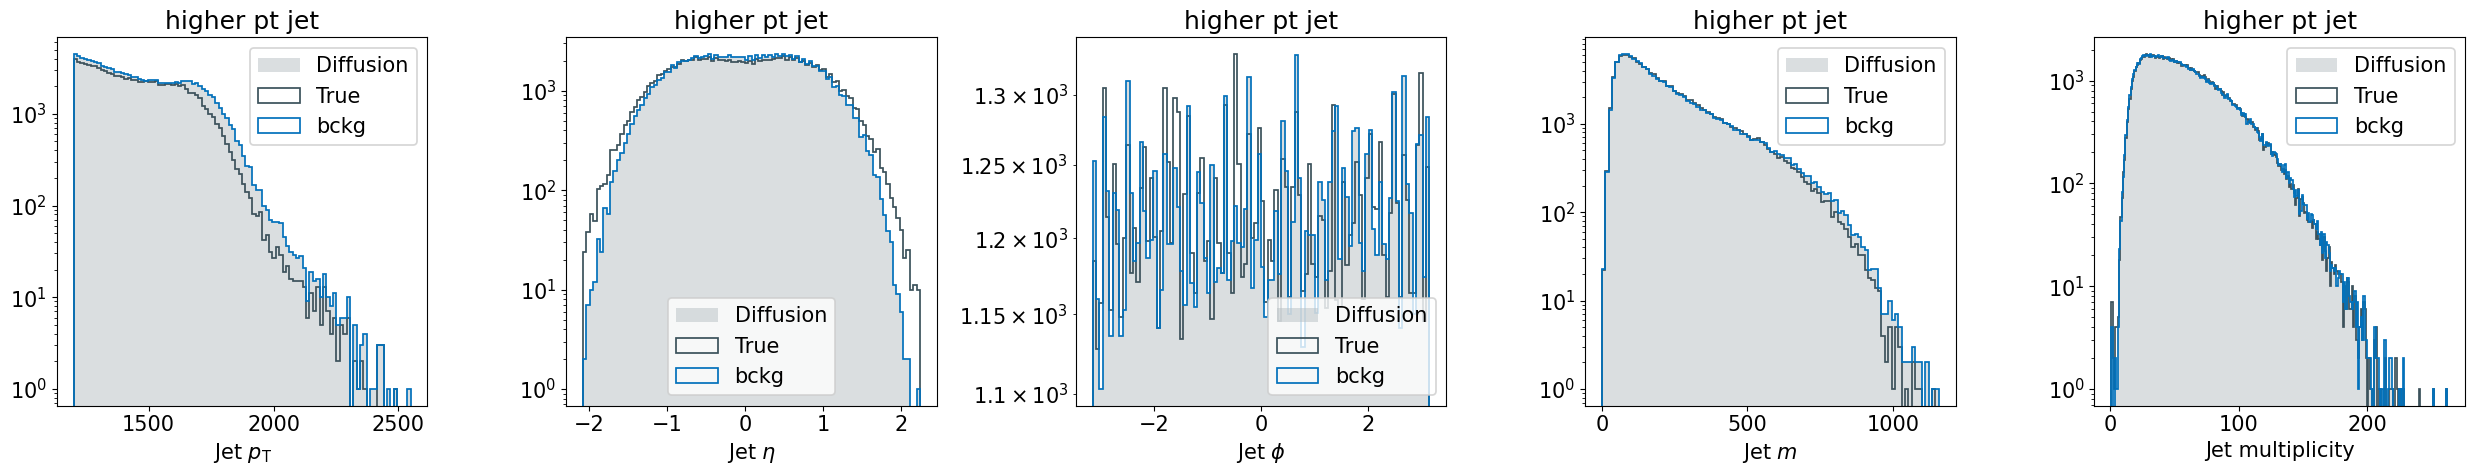

In [88]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_v[:,0, i])), int(np.max(jet_features_v[:,0, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_v[:,0, i], bins=bins, alpha=0.5, label="Diffusion", histtype="stepfilled")
    ax.hist(jet_features_c[:,0, i], bins=hist[1], label="True", histtype="step")
    ax.hist(jets_bckg[:,0, i], bins=hist[1], label="bckg", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("higher pt jet")
    ax.legend()
    ax.set_yscale("log")
plt.tight_layout()
plt.show()

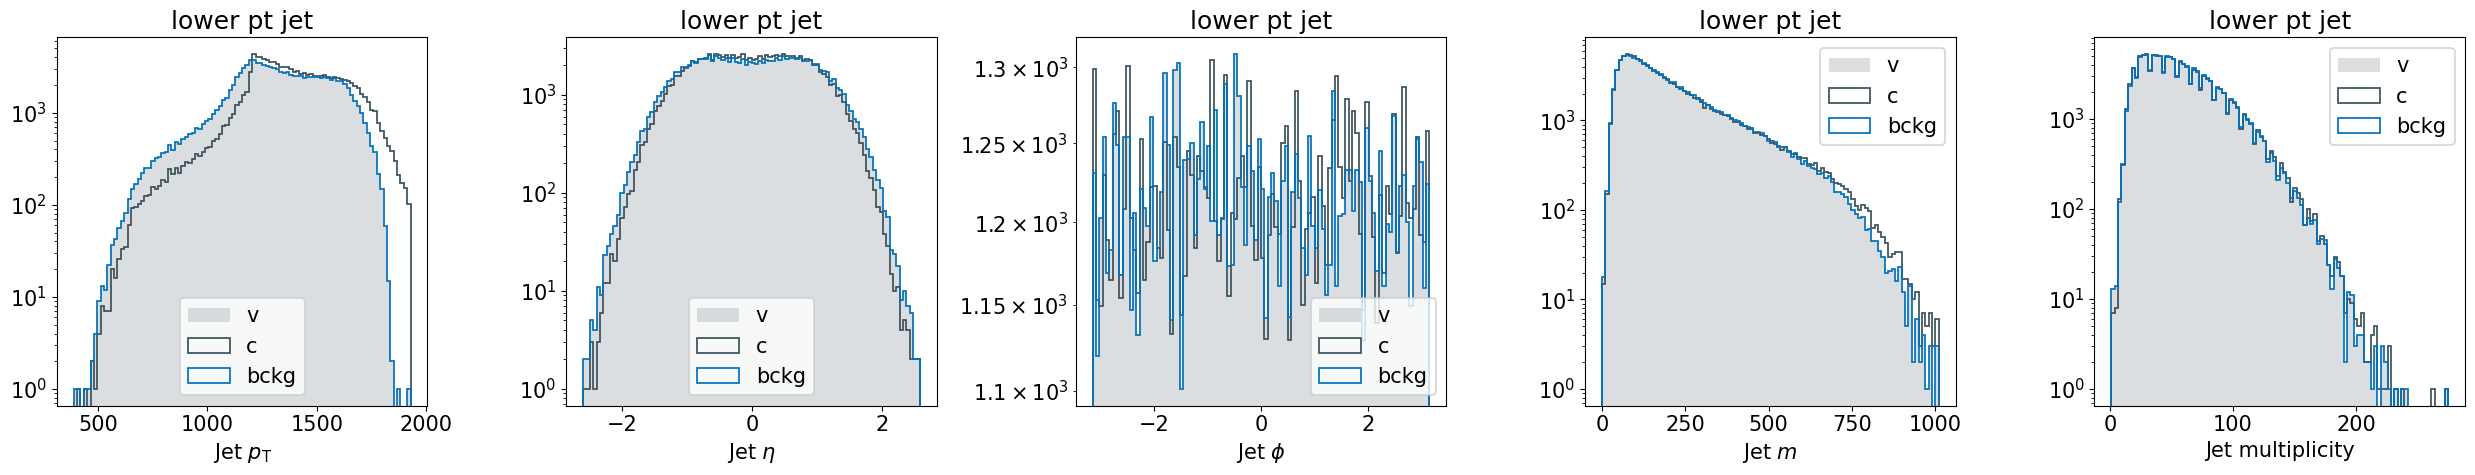

In [89]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_v[:,1, i])), int(np.max(jet_features_v[:,1, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_v[:,1, i], bins=100, alpha=0.5, label="v", histtype="stepfilled")
    ax.hist(jet_features_c[:,1, i], bins=hist[1], label="c", histtype="step")
    ax.hist(jets_bckg[:,1, i], bins=hist[1], label="bckg", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("lower pt jet")
    ax.set_yscale("log")
    ax.legend()
plt.tight_layout()
plt.show()

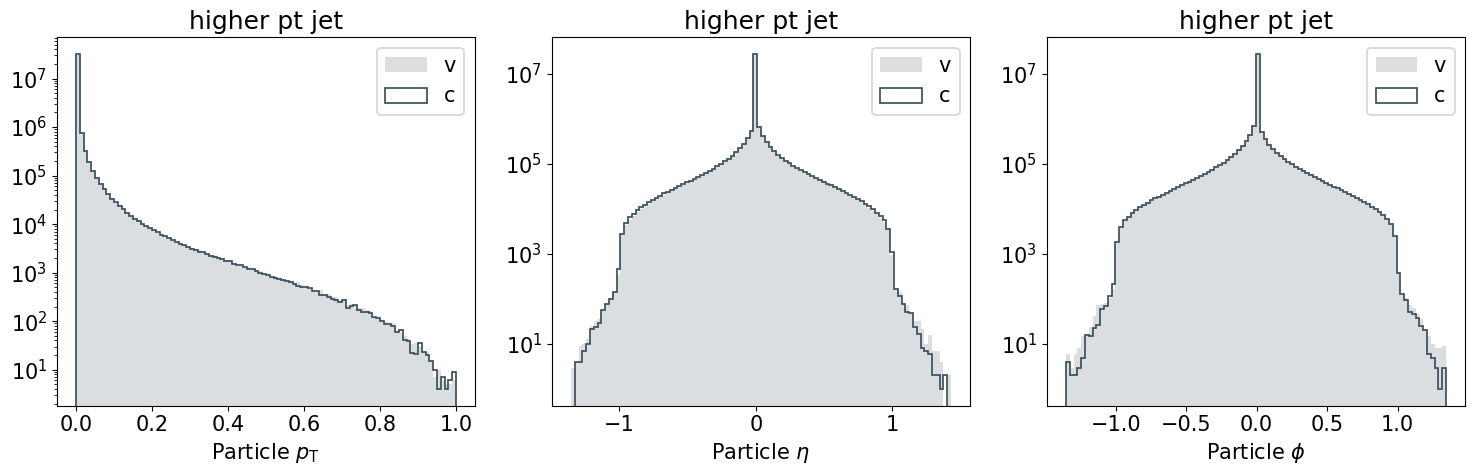

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    hist = ax.hist(particle_data_v[:,0,:, i].flatten(), bins=100, alpha=0.5, label="v", histtype="stepfilled")
    ax.hist(particle_data_c[:,0, :, i].flatten(), bins=hist[1], label="c", histtype="step")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    ax.set_title("higher pt jet")
plt.tight_layout()
plt.show()

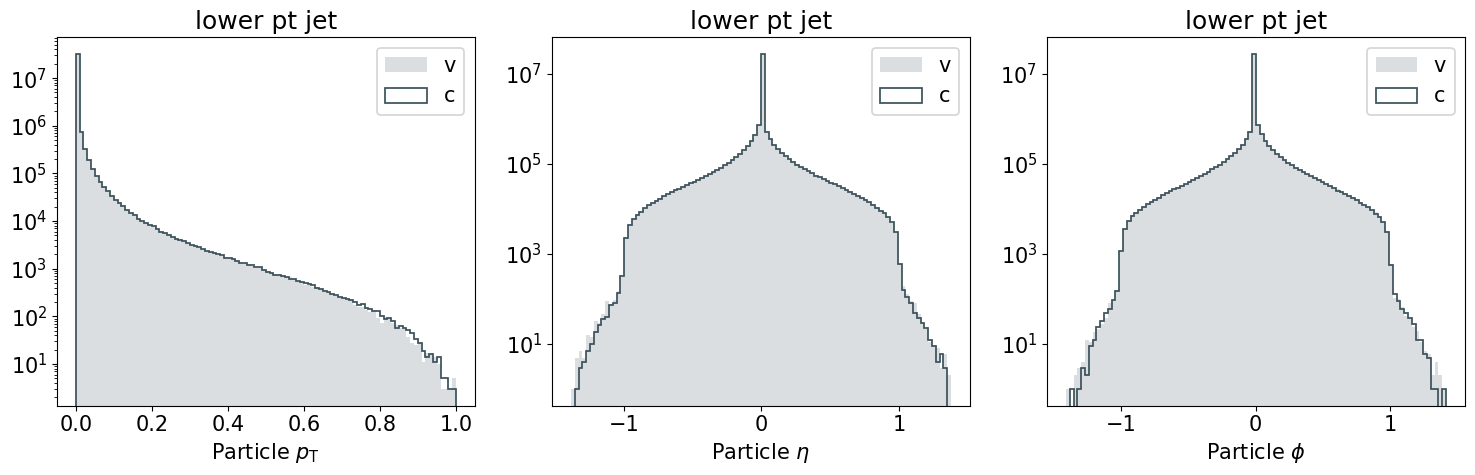

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    hist = ax.hist(particle_data_v[:,1,:, i].flatten(), bins=100, alpha=0.5, label="v", histtype="stepfilled")
    ax.hist(particle_data_c[:,1, :, i].flatten(), bins=hist[1], label="c", histtype="step")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    ax.set_title("lower pt jet")
plt.tight_layout()
plt.show()

3699.9878579973724
3699.986574532073


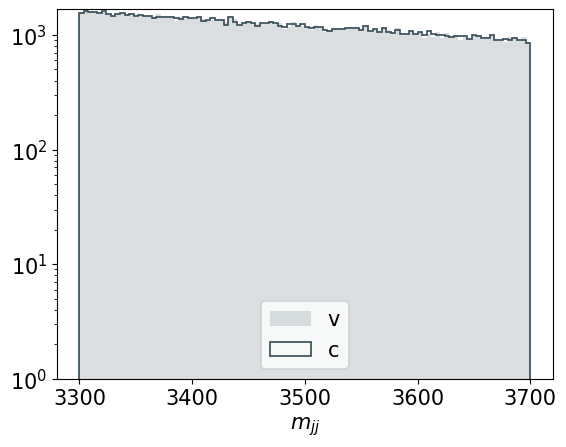

In [52]:
hist = plt.hist(mjj_v, bins=100, alpha=0.5, label="v", histtype="stepfilled")
plt.hist(mjj_c, bins=hist[1], label="c", histtype="step")

print(np.max(mjj_v))
print(np.max(mjj_c))

plt.legend()
plt.yscale("log")
plt.xlabel(r"$m_{jj}$")
plt.ylim(1)
plt.show()

In [57]:
path_cc = f"{data_folder}/lhco/generated/FM_LHCO_SR.h5"
with h5py.File(path_cc, "w") as f:
    f.create_dataset("jet_features", data=jet_features_c)
    f.create_dataset("particle_features", data=particle_data_c)
    f.create_dataset("mjj", data=mjj_c)
    
    #print(f.keys())
    #jet_features_v = f["jet_features"][:]
    #particle_data_v = f["particle_features"][:]
    #mjj_v = f["mjj"][:]

In [56]:
print(jet_features_c.shape)
print(jet_features_v.shape)
print(particle_data_c.shape)
print(particle_data_v.shape)
print(mjj_c.shape)
print(mjj_v.shape)

(121351, 2, 5)
(121351, 2, 5)
(121351, 2, 279, 3)
(121351, 2, 279, 3)
(121351,)
(121351,)


# Comparison

In [6]:
# Load vinicius data
path_v = f"{data_folder}/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_v, "r") as f:
    print(f.keys())
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]
print(jet_features_v.shape)
print(particle_data_v.shape)
print(mjj_v.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(200000, 2, 5)
(200000, 2, 279, 3)
(200000,)


In [7]:
# Load idealized data
path_id = f"{data_folder}/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_id, "r") as f:
    print(f.keys())
    jet_features_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]
    mjj_id = f["mjj"][:]
print(jet_features_id.shape)
print(particle_data_id.shape)
print(mjj_id.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(121351, 2, 5)
(121351, 2, 279, 3)
(121351,)


In [11]:
# Load ced data
path_ced = f"{data_folder}/lhco/generated/FM_LHCO_SR.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco_both_jets-midpoint-250.h5"
#path_ced = f"{data_folder}/lhco/generated/latent64-midpoint-200.h5"
#path_ced = f"{data_folder}/lhco/generated/lhco-xy-midpoint-300.h5"
with h5py.File(path_ced, "r") as f:
    print(f.keys())
    jet_features_ced = f["jet_features"][:]
    particle_data_ced = f["particle_features"][:]
    #mjj_ced = f["mjj"][:]
    #raw_ced = f["data_raw"][:]
print(jet_features_ced.shape)
print(particle_data_ced.shape)
#print(mjj_ced.shape)

<KeysViewHDF5 ['jet_features', 'mjj', 'particle_features']>
(121351, 2, 5)
(121351, 2, 279, 3)


In [27]:
particle_data_ced = raw_ced

In [28]:
particle_data_ced[...,0][particle_data_ced[...,0] < np.min(particle_data_id[...,0])] = np.min(
    particle_data_id[..., 0]
)
particle_data_ced[...,0][particle_data_ced[...,0] > np.max(particle_data_id[...,0])] = np.max(
    particle_data_id[..., 0]
)

In [29]:
#path_ced_new = f"{data_folder}/lhco/generated/lhco-xy-midpoint-300-2.h5"
#with h5py.File(path_ced_new, "w") as f:
#    f.create_dataset("jet_features", data=jet_features_ced)
#    f.create_dataset("particle_features", data=particle_data_ced)
#    f.create_dataset("mjj", data=mjj_ced)

In [12]:
particle_data_ced = particle_data_ced[...,[1,2,0]]
particle_data_id = particle_data_id[...,[1,2,0]]
particle_data_v = particle_data_v[...,[1,2,0]]

In [14]:
print(particle_data_ced.shape)


(121351, 2, 279, 3)


## Standardised data

In [144]:
inv_ced = particle_data_ced.copy()

In [60]:
print(datamodule.means)

tensor([ 5.8637e-05,  1.3587e-04, -3.4185e-03], dtype=torch.float64)


In [70]:
print(particle_data_ced[...,2].shape)
torch.tensor(particle_data_ced[...,2].copy()).unsqueeze(-1).shape

(121351, 2, 279)


torch.Size([121351, 2, 279, 1])

In [94]:
inv_ced[...,:2]= normalize_tensor(torch.tensor(particle_data_ced[...,:2].copy()), datamodule.means[:2], datamodule.stds[:2], 10).numpy()
inv_ced[...,2] = normalize_tensor(torch.tensor(particle_data_ced[...,2].copy()), [datamodule.means[2]], [datamodule.stds[2]], 1).numpy()

In [74]:
print(inv_ced.shape)

(121351, 2, 279, 3)


In [92]:
inv_ced[...,2] = np.ma.log(1.0 - inv_ced[..., 2]).filled(0)

In [46]:
print(inv_ced.shape)

(121351, 2, 279, 3)


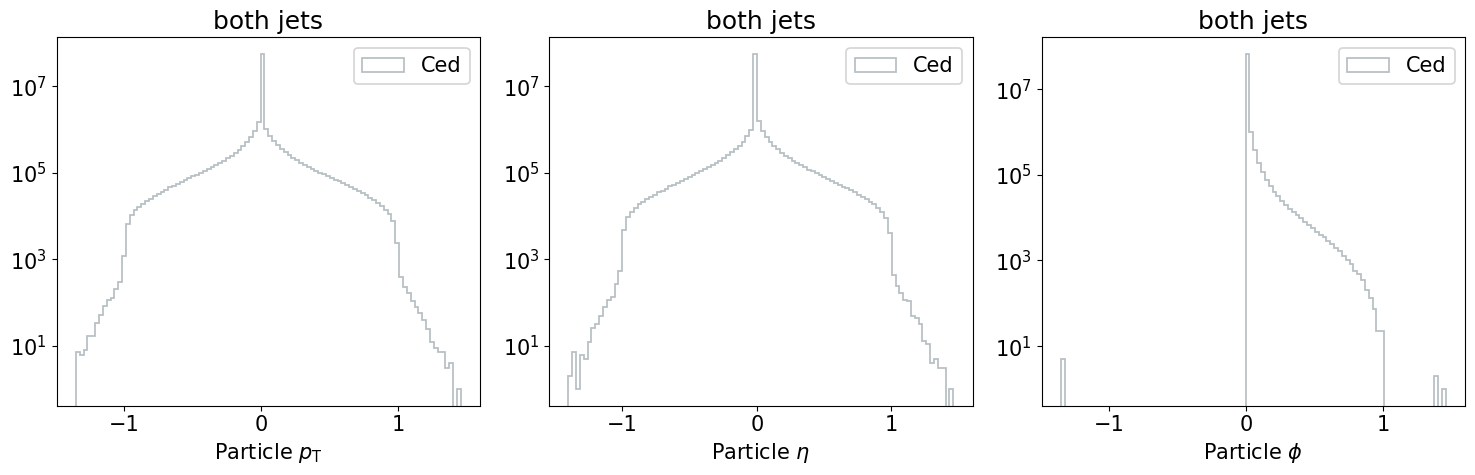

In [145]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    
    ax.hist(inv_ced[:,:, :, i].flatten(), bins=100, label="Ced", histtype="step")
    #ax.hist(particle_data_v[:,:, :, i].flatten()[particle_data_v[:,:,:, i].flatten() != 0], bins=100, label="Vini", histtype="step")
    #hist = ax.hist(particle_data_id[:,:,:, i].flatten()[particle_data_id[:,:,:, i].flatten() != 0], bins=100, alpha=0.5, label="Hist", histtype="stepfilled")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    #if i == 2:
    #    ax.set_xscale("log")
    ax.set_title("both jets")
plt.tight_layout()
plt.show()

## post-processing

In [33]:
#particle_data_ced[particle_data_ced[...,2] > 1] = np.max(
#    particle_data_id[..., 2]
#)
#particle_data_ced[particle_data_ced[...,2] < 0] = np.min(
#    particle_data_id[..., 2]
#)
print(np.max(particle_data_ced[...,2]))
print(np.max(particle_data_ced[...,0]))
print(np.min(particle_data_ced[...,0]))

print(np.max(particle_data_id[...,2]))
print(np.max(particle_data_id[...,0]))
print(np.min(particle_data_id[...,0]))


particle_data_ced[particle_data_ced[...,2] < np.min(particle_data_id[...,2])] = np.min(
    particle_data_id[..., 2]
)



particle_data_ced[...,0][particle_data_ced[...,0] < np.min(particle_data_id[...,0])] = np.min(
    particle_data_id[..., 0]
)
particle_data_ced[...,1][particle_data_ced[...,1] < np.min(particle_data_id[...,1])] = np.min(
    particle_data_id[..., 1]
)
particle_data_ced[...,2][particle_data_ced[...,2] > np.max(particle_data_id[...,2])] = np.max(
    particle_data_id[..., 2]
)
particle_data_ced[...,1][particle_data_ced[...,1] > np.max(particle_data_id[...,1])] = np.max(
    particle_data_id[..., 1]
)
particle_data_ced[...,0][particle_data_ced[...,0] > np.max(particle_data_id[...,0])] = np.max(
    particle_data_id[..., 0]
)

print(np.max(particle_data_ced[...,2]))
print(np.max(particle_data_ced[...,0]))
print(np.min(particle_data_ced[...,0]))


0.99980515
1.4829512
-1.4143244
1.0000000000000002
1.4602784677149572
-1.3550398196628055
0.99980515
1.4602785
-1.3550398


In [ ]:
print(np.max(particle_data_id[...,0]))
print(np.max(particle_data_v[...,1]))
print(np.max(particle_data_ced[...,0]))
print(particle_data_ced.shape)
print(particle_data_ced[0,:,:10])

print(particle_data_id.shape)

In [16]:
jet_features_v = jet_features_v[:len(jet_features_ced)]
particle_data_v = particle_data_v[:len(particle_data_ced)]
#mjj_v = mjj_v[:len(mjj_ced)]

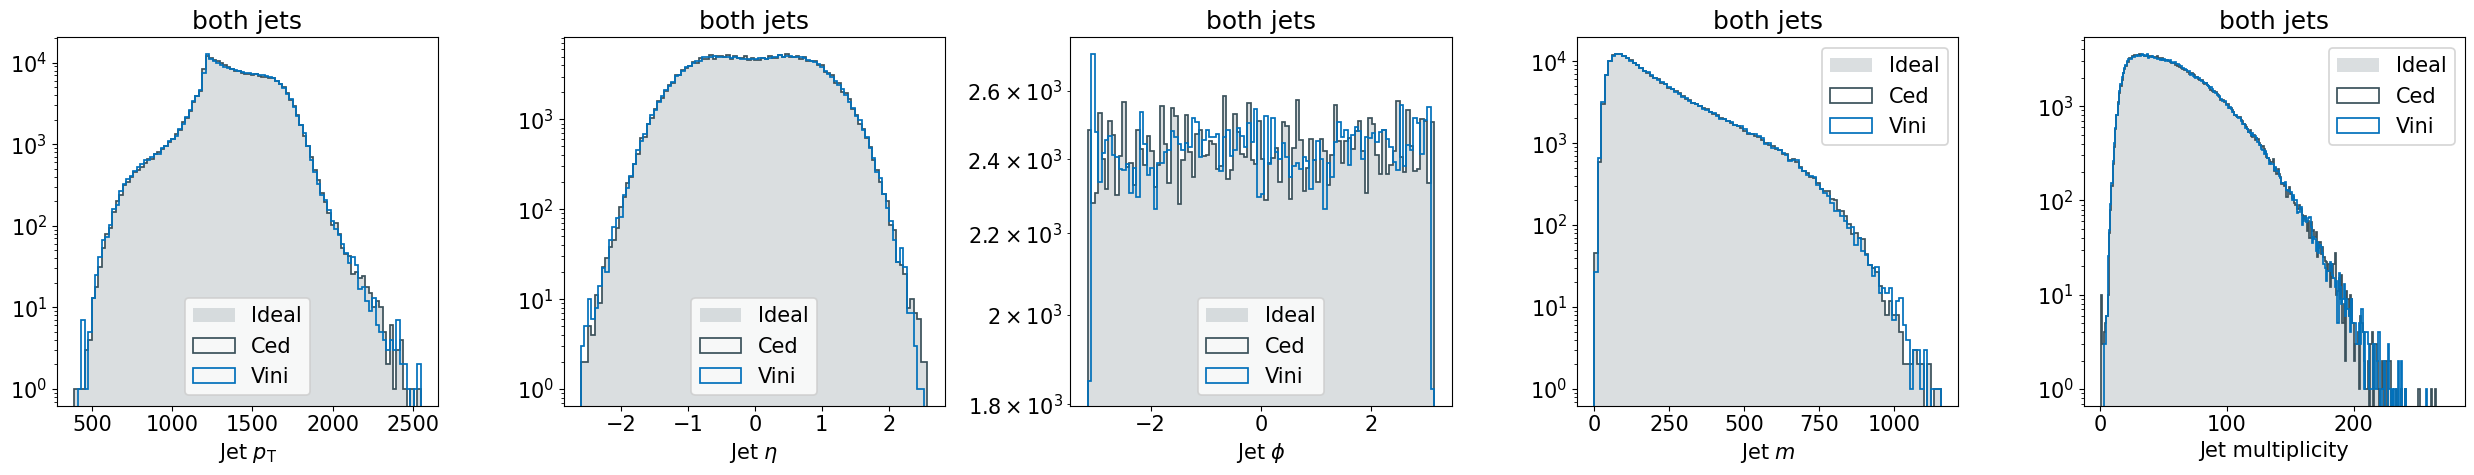

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_id[:,:, i])), int(np.max(jet_features_id[:,:, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_id[:,:, i].flatten(), bins=bins, alpha=0.5, label="Ideal", histtype="stepfilled")
    ax.hist(jet_features_ced[:,:, i].flatten(), bins=hist[1], label="Ced", histtype="step")
    ax.hist(jet_features_v[:,:, i].flatten(), bins=hist[1], label="Vini", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("both jets")
    ax.legend()
    ax.set_yscale("log")
plt.tight_layout()
plt.show()

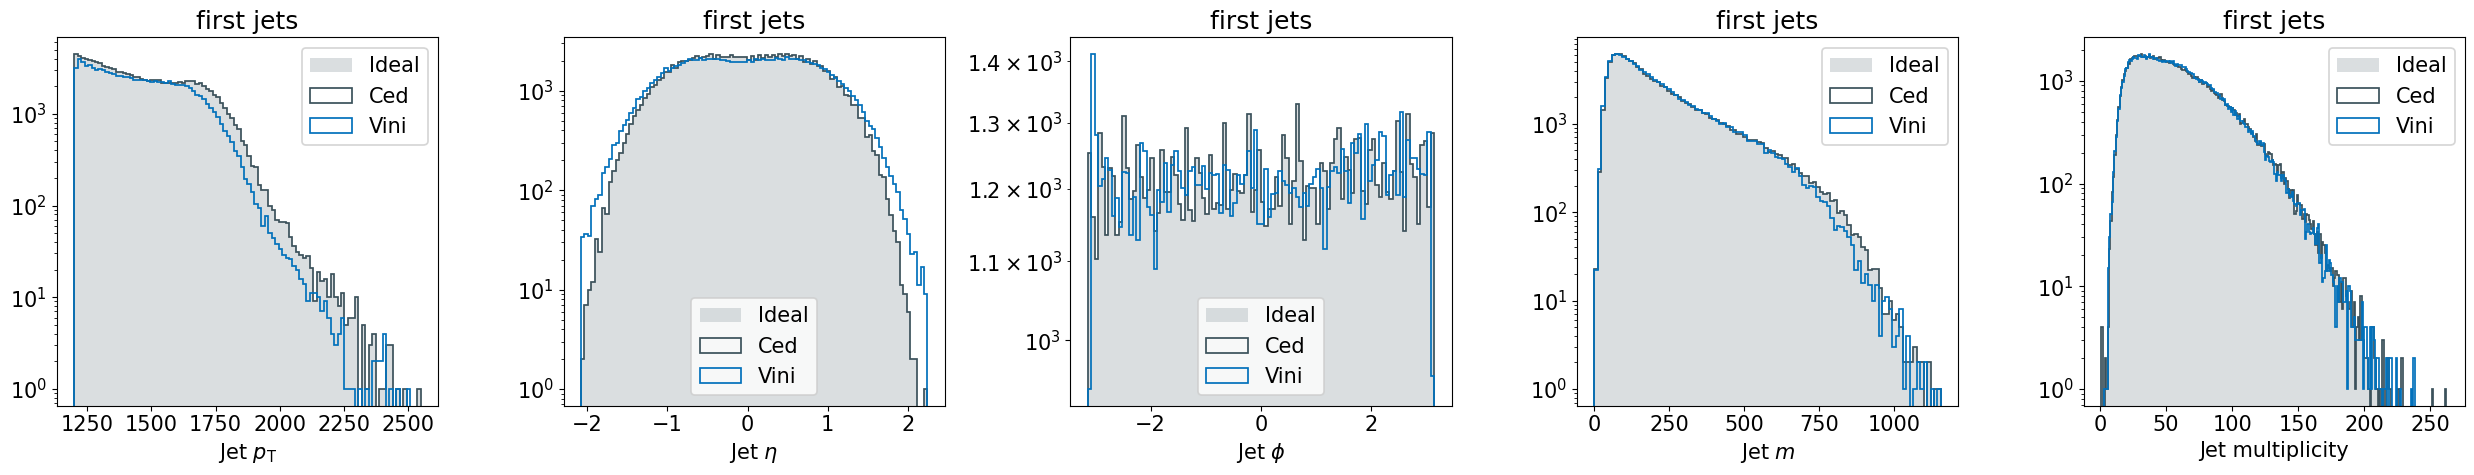

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_id[:,0, i])), int(np.max(jet_features_id[:,0, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_id[:,0, i], bins=bins, alpha=0.5, label="Ideal", histtype="stepfilled")
    ax.hist(jet_features_ced[:,0, i], bins=hist[1], label="Ced", histtype="step")
    ax.hist(jet_features_v[:,0, i], bins=hist[1], label="Vini", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("first jets")
    ax.legend()
    ax.set_yscale("log")
plt.tight_layout()
plt.show()

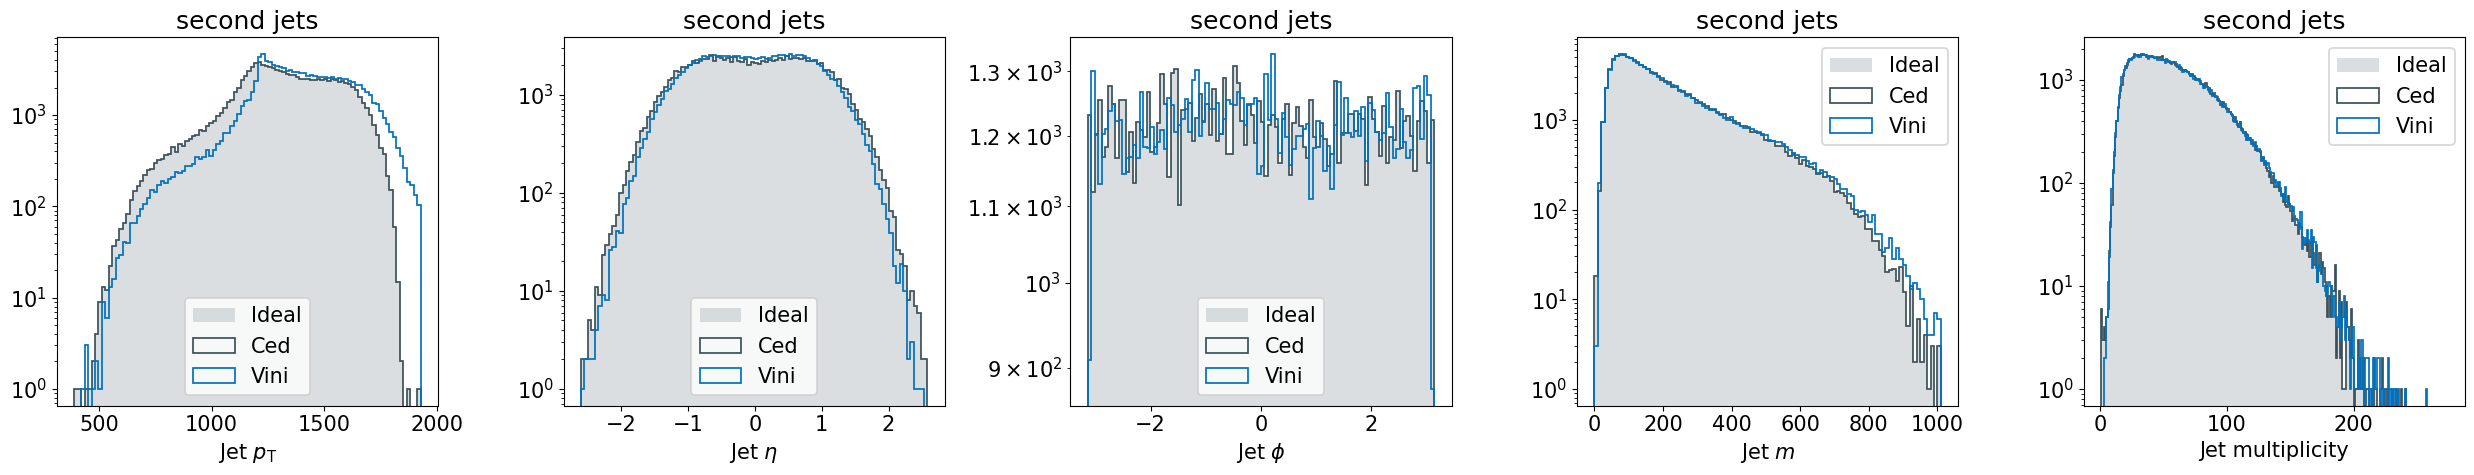

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
labels = [r"Jet $p_\mathrm{T}$", r"Jet $\eta$", r"Jet $\phi$", r"Jet $m$", "Jet multiplicity"]
for i, ax in enumerate(axs):
    if i == 4:
        bins = range(int(np.min(jet_features_id[:,1, i])), int(np.max(jet_features_id[:,1, i])))
    else:
        bins = 100
    
    hist = ax.hist(jet_features_id[:,1, i], bins=bins, alpha=0.5, label="Ideal", histtype="stepfilled")
    ax.hist(jet_features_ced[:,1, i], bins=hist[1], label="Ced", histtype="step")
    ax.hist(jet_features_v[:,1, i], bins=hist[1], label="Vini", histtype="step")
    ax.set_xlabel(labels[i])
    ax.set_title("second jets")
    ax.legend()
    ax.set_yscale("log")
plt.tight_layout()
plt.show()

# Particle Features

In [38]:
print(np.max(particle_data_id[...,0]))
print(np.max(particle_data_v[...,1]))
print(np.max(particle_data_ced[...,0]))
print(particle_data_ced.shape)
print(particle_data_ced[0,:,:10])

print(particle_data_id.shape)

1.4602784677149572
1.4129922468888043
1.4602785
(121351, 2, 279, 3)
[[[-1.30179543e-02 -4.55753354e-04  1.11359663e-01]
  [ 7.36975893e-02  1.43540557e-02  2.00995989e-03]
  [ 2.10217208e-01 -1.58283159e-01  7.49683008e-04]
  [ 1.20901123e-01 -2.61234313e-01  1.56200491e-03]
  [ 1.49351945e-02  9.44573060e-02  3.43811326e-03]
  [ 4.45037708e-03 -8.76573380e-04  6.99538350e-01]
  [-1.84002649e-02  8.54804274e-03  2.97030453e-02]
  [ 3.01064402e-02  9.03999247e-03  1.09670870e-03]
  [-7.12628476e-03  6.26595598e-03  1.20796002e-01]
  [-7.75696151e-03 -1.63559485e-02  2.72866394e-02]]

 [[-6.42825007e-01 -4.27965254e-01  1.17855836e-02]
  [ 1.82173580e-01  1.32121909e-02  9.40216705e-04]
  [ 5.94384193e-01 -6.46922290e-01  6.74545765e-04]
  [ 3.94275695e-01 -8.28410923e-01  1.67772360e-03]
  [ 5.55702485e-02  1.96700796e-01  1.81025639e-03]
  [ 1.51392967e-02  1.85141135e-02  4.77989823e-01]
  [-2.09075332e-01  8.52948874e-02  2.80289631e-03]
  [ 5.66448644e-02  4.85356711e-03  8.36864114

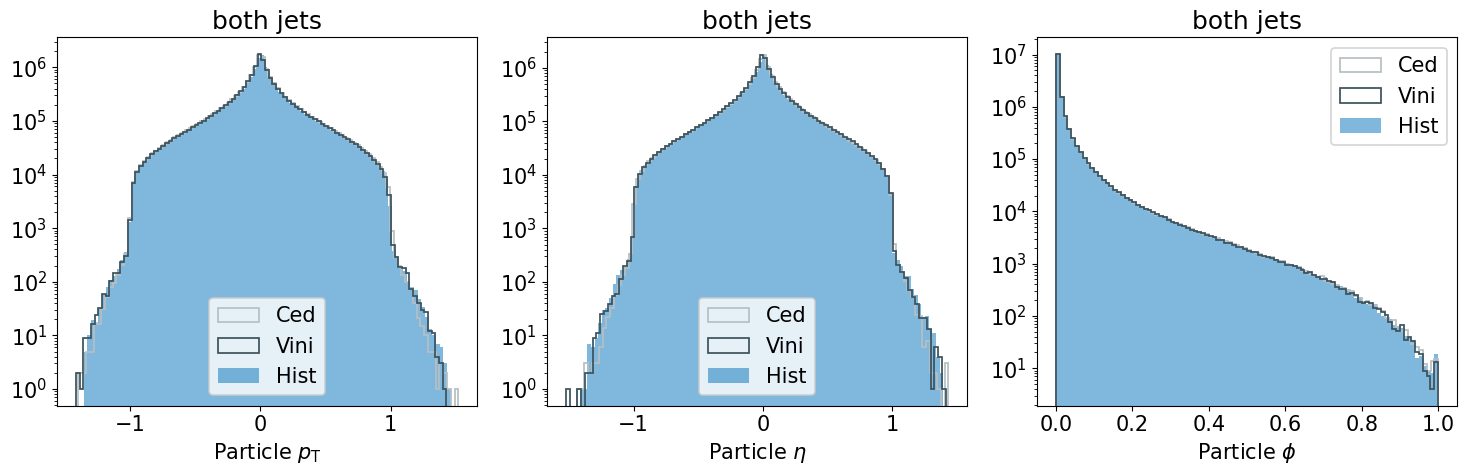

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    
    ax.hist(particle_data_ced[:,:, :, i].flatten()[particle_data_ced[:,:,:, i].flatten() != 0], bins=100, label="Ced", histtype="step")
    ax.hist(particle_data_v[:,:, :, i].flatten()[particle_data_v[:,:,:, i].flatten() != 0], bins=100, label="Vini", histtype="step")
    hist = ax.hist(particle_data_id[:,:,:, i].flatten()[particle_data_id[:,:,:, i].flatten() != 0], bins=100, alpha=0.5, label="Hist", histtype="stepfilled")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    #if i == 2:
    #    ax.set_xscale("log")
    ax.set_title("both jets")
plt.tight_layout()
plt.show()

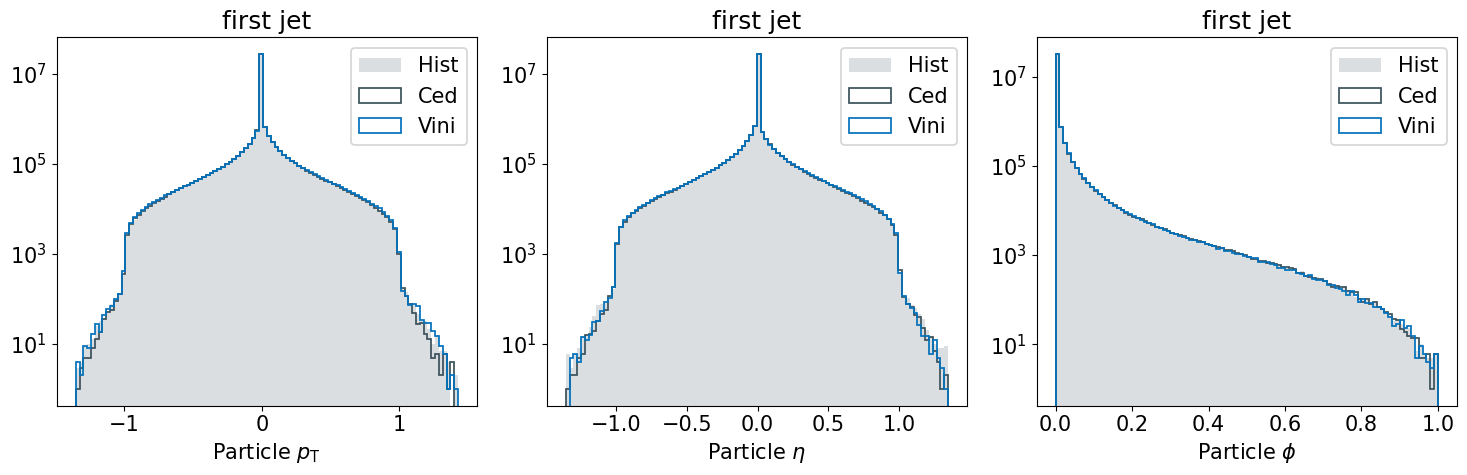

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    hist = ax.hist(particle_data_id[:,0,:, i].flatten(), bins=100, alpha=0.5, label="Hist", histtype="stepfilled")
    ax.hist(particle_data_ced[:,0, :, i].flatten(), bins=hist[1], label="Ced", histtype="step")
    ax.hist(particle_data_v[:,0, :, i].flatten(), bins=hist[1], label="Vini", histtype="step")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    ax.set_title("first jet")
plt.tight_layout()
plt.show()

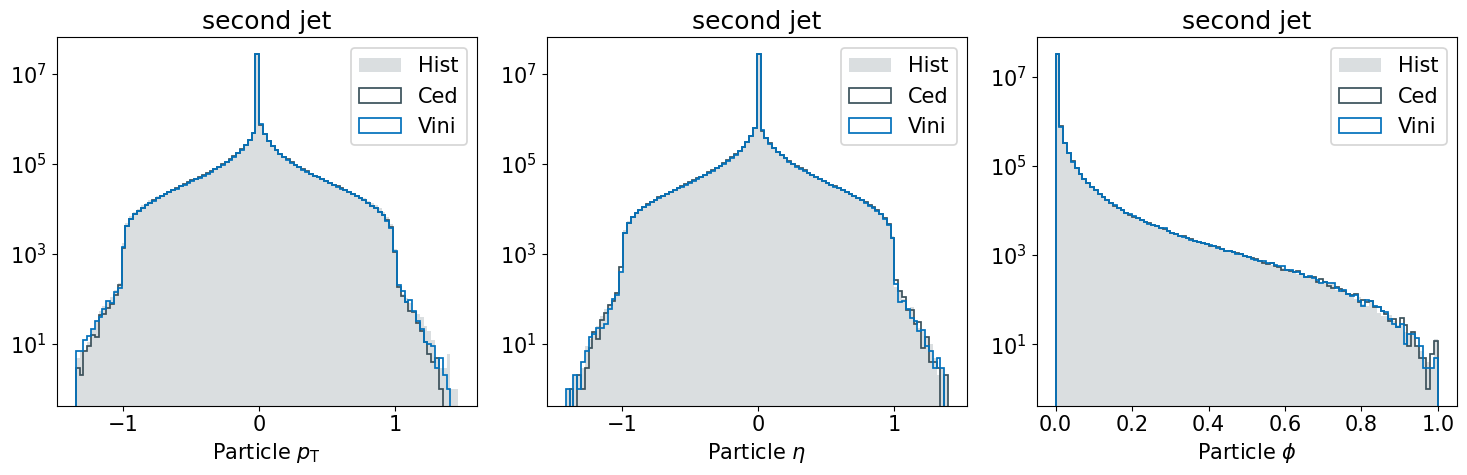

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
labels = [r"Particle $p_\mathrm{T}$", r"Particle $\eta$", r"Particle $\phi$"]
for i, ax in enumerate(axs):
    hist = ax.hist(particle_data_id[:,1,:, i].flatten(), bins=100, alpha=0.5, label="Hist", histtype="stepfilled")
    ax.hist(particle_data_ced[:,1, :, i].flatten(), bins=hist[1], label="Ced", histtype="step")
    ax.hist(particle_data_v[:,1, :, i].flatten(), bins=hist[1], label="Vini", histtype="step")
    ax.legend()
    ax.set_xlabel(labels[i])
    ax.set_yscale("log")
    ax.set_title("second jet")
plt.tight_layout()
plt.show()

In [42]:
print(particle_data_id.shape)

(121351, 2, 279, 3)


In [20]:
particle_data_id_full = particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1])
particle_data_v_full = particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1])
particle_data_ced_full = particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1])

In [21]:
plot_config_x = {
    "num_samples": len(particle_data_id_full),
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": False,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "sim_data",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
    "labels": ["FM","FPCD"]
}
plot_prep_config_x = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [22]:
(
    jet_data_x,
    efps_values_x,
    pt_selected_particles_x,
    pt_selected_multiplicities_x,
) = prepare_data_for_plotting(
    np.array([particle_data_ced_full, particle_data_v_full]),
    **plot_prep_config_x,
)

In [23]:
(
    jet_data_sim_x,
    efps_sim_x,
    pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim_x,
) = prepare_data_for_plotting(
    [particle_data_id_full],
    **plot_prep_config_x,
)
jet_data_sim_x, efps_sim_x, pt_selected_particles_sim_x = (
    jet_data_sim_x[0],
    efps_sim_x[0],
    pt_selected_particles_sim_x[0],
)

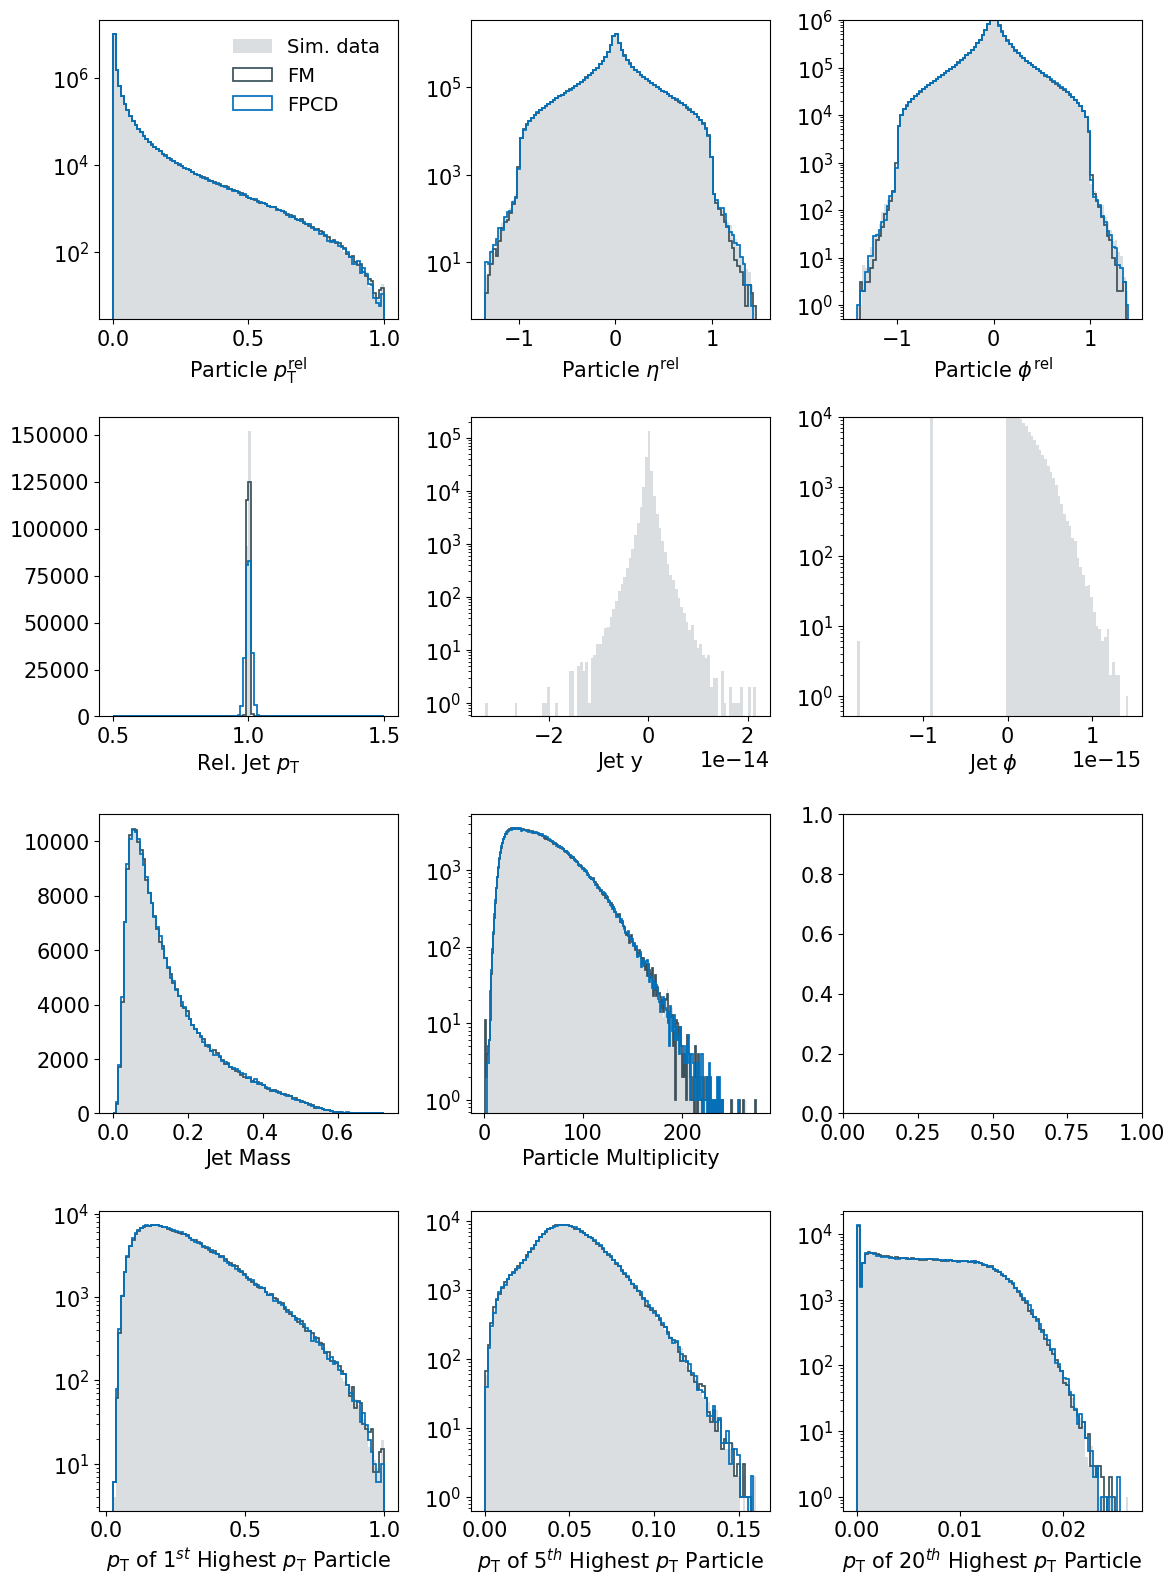

In [24]:
fig_x = plot_data(
    particle_data=np.array([particle_data_ced_full, particle_data_v_full]),
    sim_data=particle_data_id_full,
    jet_data_sim=jet_data_sim_x,
    jet_data=jet_data_x,
    efps_sim=efps_sim_x,
    efps_values=efps_values_x,
    pt_selected_particles=pt_selected_particles_x,
    pt_selected_multiplicities=pt_selected_multiplicities_x,
    pt_selected_particles_sim=pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x,
    **plot_config_x,
)

## mjj

In [34]:
#cond_ced = jet_features_ced.reshape(-1, jet_features_ced.shape[-1])
#cond_v = jet_features_v.reshape(-1, jet_features_v.shape[-1])

In [51]:
def get_nonrel_coordinates(particle_data: np.array, cond: np.array) -> np.array:
    """
    particle data features in eta, phi, pt
    """
    pt = np.expand_dims(cond[..., 0],axis=-1)
    eta = np.expand_dims(cond[..., 1],axis=-1)
    phi = np.expand_dims(cond[..., 2],axis=-1)
    
    mask_nonrel = np.expand_dims((particle_data[..., 2] > 0).astype(int), axis=-1)
    non_rel_eta = np.expand_dims(particle_data.copy()[..., 0] + eta, axis=-1)
    non_rel_phi = np.expand_dims(particle_data.copy()[..., 1] + phi, axis=-1)
    # wrap phi between -pi and pi
    non_rel_phi = np.where(
        non_rel_phi > np.pi,
        non_rel_phi - 2 * np.pi,
        non_rel_phi,
    )
    non_rel_phi = np.where(
        non_rel_phi < -np.pi,
        non_rel_phi + 2 * np.pi,
        non_rel_phi,
    )
    non_rel_pt = np.expand_dims(particle_data.copy()[..., 2] * pt, axis=-1)
    # fix the masking
    non_rel_eta = non_rel_eta * mask_nonrel
    non_rel_phi = non_rel_phi * mask_nonrel
    data_nonrel = np.concatenate([non_rel_eta, non_rel_phi, non_rel_pt], axis=-1)
    return data_nonrel

In [52]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [53]:
data_nonrel_ced = get_nonrel_coordinates(particle_data_ced, jet_features_ced)
data_nonrel_v = get_nonrel_coordinates(particle_data_v, jet_features_v)

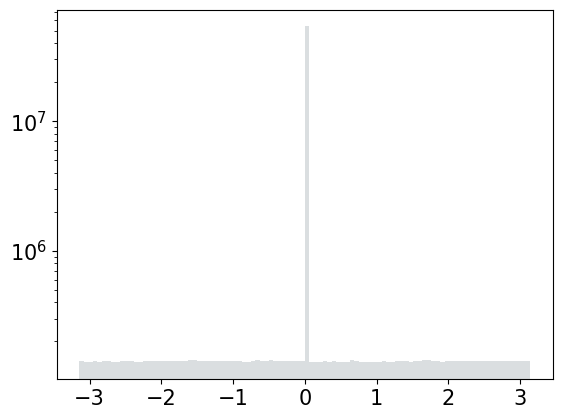

In [56]:
plt.hist(data_nonrel_ced[:,:,:,1].flatten(), bins=100, alpha=0.5, label="ced", histtype="stepfilled")
plt.yscale("log")
plt.show()

In [57]:
jet_data_nonrel_ced = get_jet_data(data_nonrel_ced[...,[2,0,1]])
jet_data_nonrel_v = get_jet_data(data_nonrel_v[...,[2,0,1]])

In [58]:
# cut mjj window
p4_jets_ced = ef.p4s_from_ptyphims(jet_data_nonrel_ced)
# get mjj from p4_jets
sum_p4_ced = p4_jets_ced[:, 0] + p4_jets_ced[:, 1]
mjj_ced = ef.ms_from_p4s(sum_p4_ced)

In [59]:
# cut mjj window
p4_jets_v = ef.p4s_from_ptyphims(jet_data_nonrel_v)
# get mjj from p4_jets
sum_p4_v = p4_jets_v[:, 0] + p4_jets_v[:, 1]
mjj_v = ef.ms_from_p4s(sum_p4_v)

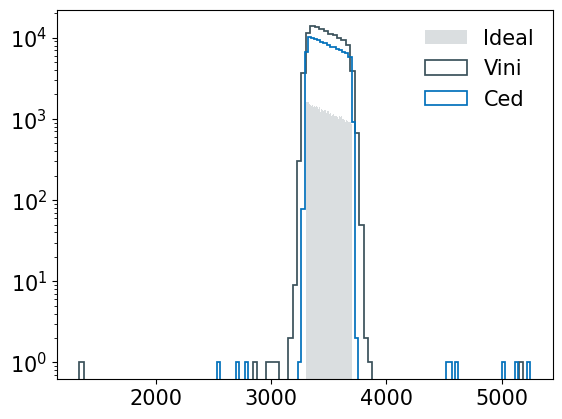

In [68]:
hist = plt.hist(mjj_id, bins=100, alpha=0.5, label="Ideal", histtype="stepfilled")
plt.hist(mjj_v, bins=100, label="Vini", histtype="step")
plt.hist(mjj_ced, bins=100, label="Ced", histtype="step")
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

In [81]:
print(mjj_ced.shape)
print(np.sum((mjj_ced < 3300) | (mjj_ced > 3700)))
args_mjj = ~((mjj_ced < 3300) | (mjj_ced > 3700))

(121351,)
1590


In [82]:
particle_data_ced = particle_data_ced[args_mjj]
jet_features_ced = jet_features_ced[args_mjj]

# post processing

(119761, 3)


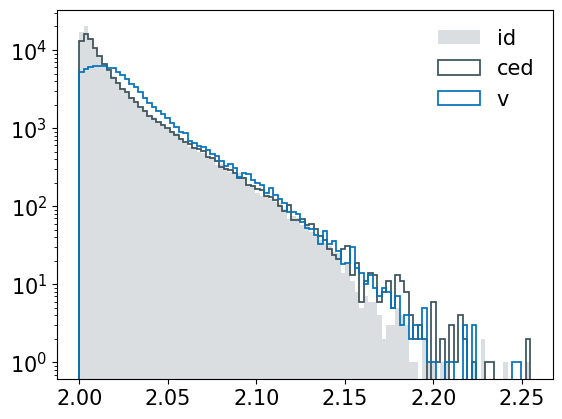

In [99]:
sum_features_id = np.sum(particle_data_id, axis=(-2,-3))
sum_features_ced = np.sum(particle_data_ced, axis=(-2,-3))
sum_features_v = np.sum(particle_data_v, axis=(-2,-3))
print(sum_features_ced.shape)

feat = 2
hist = plt.hist(sum_features_id[...,feat].flatten(), bins=100, alpha=0.5, label="id", histtype="stepfilled")
plt.hist(sum_features_ced[...,feat].flatten(), bins=hist[1], label="ced", histtype="step")
plt.hist(sum_features_v[...,feat].flatten(), bins=hist[1], label="v", histtype="step")
plt.legend(frameon=False)
plt.yscale("log")
plt.show()


## wasserstein

In [84]:
particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1])[:50000].shape

(50000, 279, 3)

In [48]:
w_dists = calculate_all_wasserstein_metrics(
    particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40, calculate_efps=True
)
print(w_dists)

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/awkward/_connect/numpy.py:403: RuntimeWarning: invalid value encountered in sqrt
  result = impl(*args, **kwargs)


{'w1m_mean': 0.0008189619807253632, 'w1m_std': 0.0003626680059638887, 'w1p_mean': 0.0006422661098579248, 'w1p_std': 0.0002685862664792597, 'w1efp_mean': 0.000268900289134282, 'w1efp_std': 0.0001086253303826832}


In [67]:
w_dists = calculate_all_wasserstein_metrics(
    particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40, calculate_efps=True
)
print(w_dists)

{'w1m_mean': 0.0009108575978350651, 'w1m_std': 0.0003626450841163159, 'w1p_mean': 0.0007416533924862693, 'w1p_std': 0.0002919581465154937, 'w1efp_mean': 0.0003440645386978391, 'w1efp_std': 0.00010836240370080352}


In [13]:
w_dists = calculate_all_wasserstein_metrics(
    particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40, calculate_efps=True
)
print(w_dists)

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/awkward/_connect/numpy.py:403: RuntimeWarning: invalid value encountered in sqrt
  result = impl(*args, **kwargs)


{'w1m_mean': 0.0009425802651664833, 'w1m_std': 0.0003983390662601528, 'w1p_mean': 0.0011235406143236142, 'w1p_std': 0.0003489323370724825, 'w1efp_mean': 0.00039958447264851085, 'w1efp_std': 0.00016335667081713467}


In [80]:
wdist_p_ced = w1p_return_all(particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40,exclude_zeros=True)
print(wdist_p_ced)

[[0.0018418757678341187, 0.0017856373472525436, 9.222821603115165e-05], [0.0016633241433404377, 0.0013675495907025993, 6.502141287219475e-05], [0.002118841411830772, 0.001637576662340154, 7.708695742662325e-05], [0.0017985780301105429, 0.001167794689080421, 4.9121077881761945e-05], [0.002237956560304883, 0.0006493775312294621, 4.9505597059237975e-05], [0.0014299961603574034, 0.0023261333951171445, 4.8889708384044924e-05], [0.002709508074781819, 0.0011734487450382922, 8.305662089487988e-05], [0.0022772197581136205, 0.001352501272997484, 5.8616812513862414e-05], [0.002114761392150864, 0.0007953920611105188, 6.875868847997376e-05], [0.0019922861814135723, 0.0005989643525808966, 5.7271993466438124e-05], [0.0019236224003711876, 0.0014048229566909524, 0.00010886076236743754], [0.0013186331403075274, 0.0009379385631291625, 8.470957105036711e-05], [0.0018639130725906234, 0.001202577569167948, 4.0502780824545625e-05], [0.0020488791727848164, 0.0023127971647707774, 0.00013525444837608666], [0.00

In [6]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [88]:
wdist_p_id = w1p(particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40,exclude_zeros=True)
print(wdist_p_id)

(array([1.02438010e-03, 8.56552444e-04, 6.93124303e-05]), array([3.99188639e-04, 3.44938450e-04, 3.36735455e-05]))


In [89]:
wdist_p_v = w1p(particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40,exclude_zeros=True)
print(wdist_p_v)

(array([9.72519530e-04, 1.15496860e-03, 9.52395271e-05]), array([3.24246269e-04, 4.36858738e-04, 3.02694397e-05]))


In [16]:
wdist_p_ced = w1p(particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1]), particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1]), num_eval_samples=50_000, num_batches=40,exclude_zeros=True)
print(wdist_p_ced)

(array([0.00149671, 0.00172281, 0.00010243]), array([4.55461811e-04, 5.22655210e-04, 2.49478766e-05]))


Computing substructure variables: 100%|██████████| 10000/10000 [03:36<00:00, 46.17it/s]


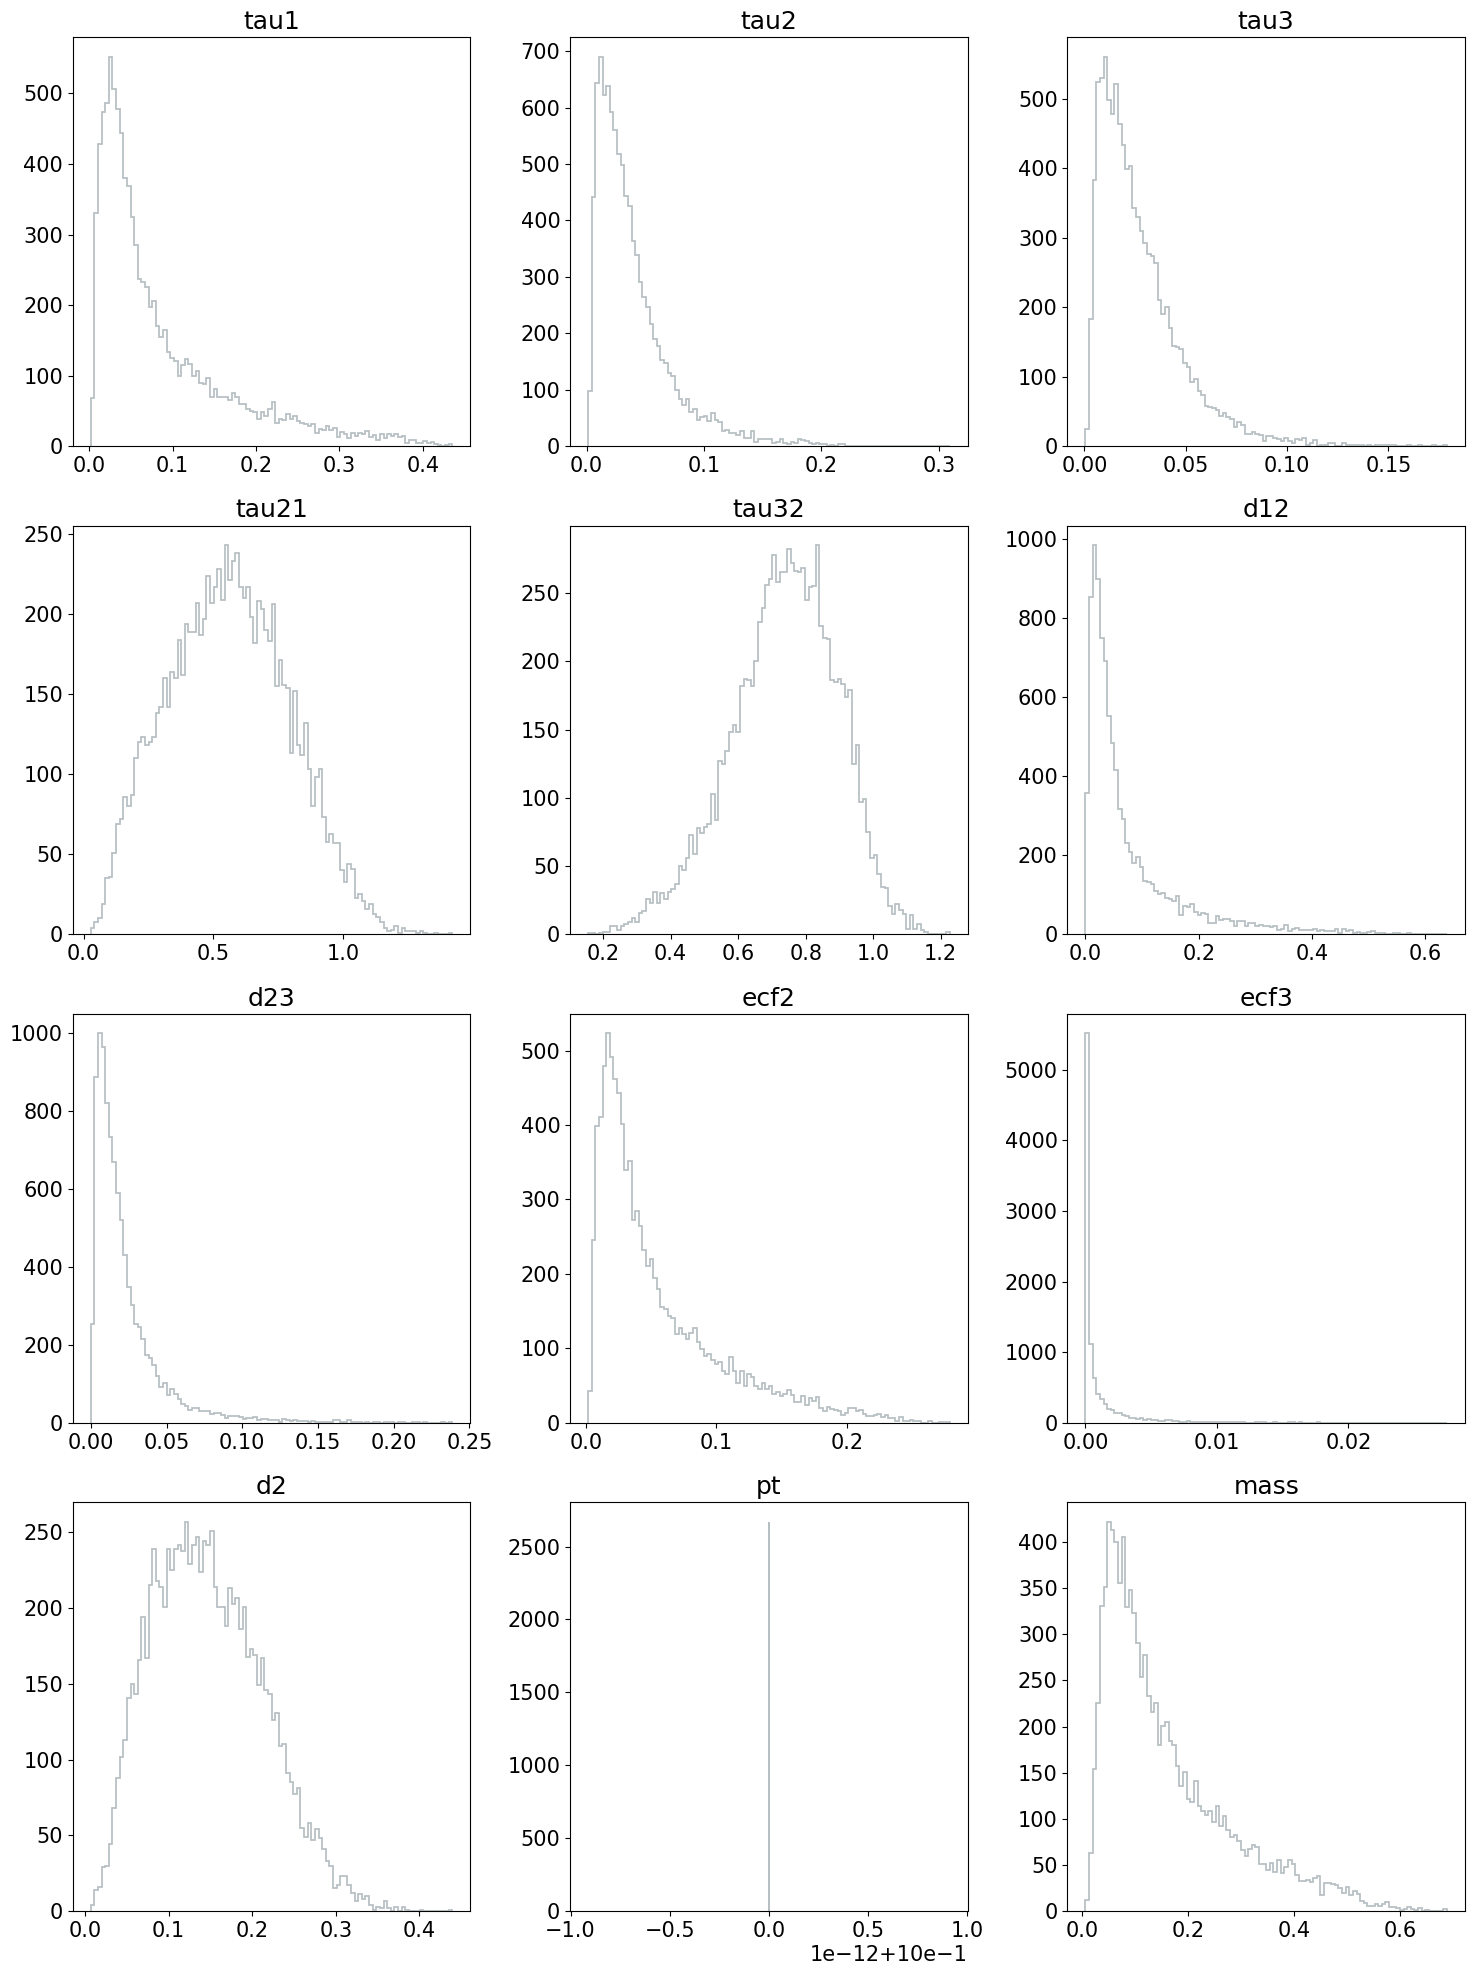

In [93]:
dump_hlvs(
    particle_data_id.reshape(-1, particle_data_id.shape[-2], particle_data_id.shape[-1])[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_id",
    plot=True,
)

Computing substructure variables: 100%|██████████| 10000/10000 [03:30<00:00, 47.44it/s]


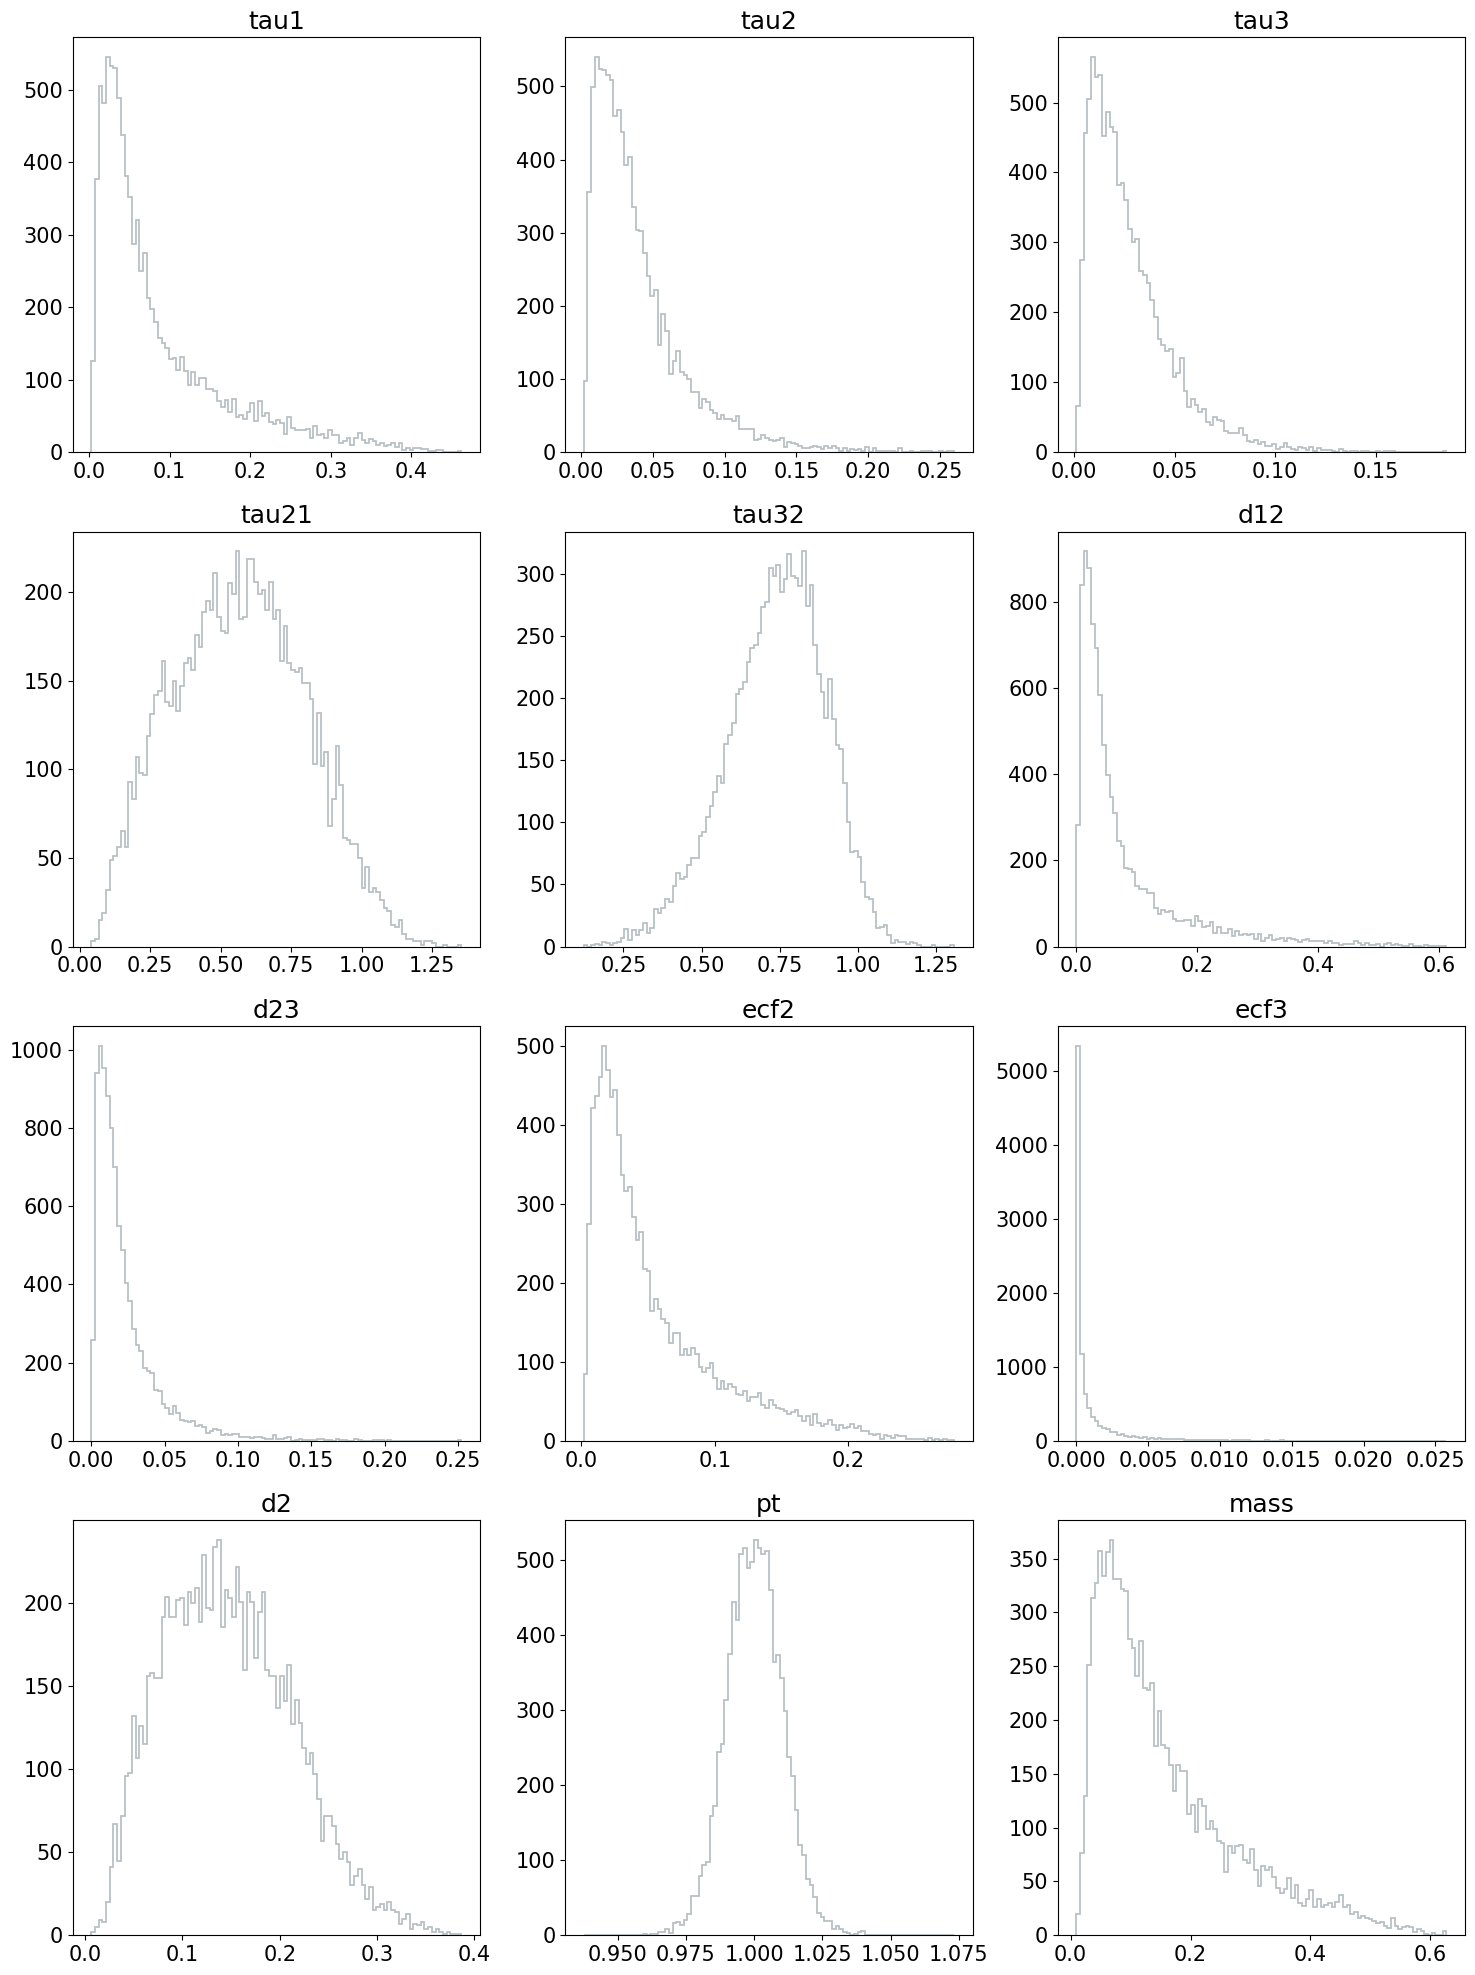

In [99]:
dump_hlvs(
    particle_data_v.reshape(-1, particle_data_v.shape[-2], particle_data_v.shape[-1])[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_v",
    plot=True,
)

Computing substructure variables: 100%|██████████| 10000/10000 [03:23<00:00, 49.14it/s]


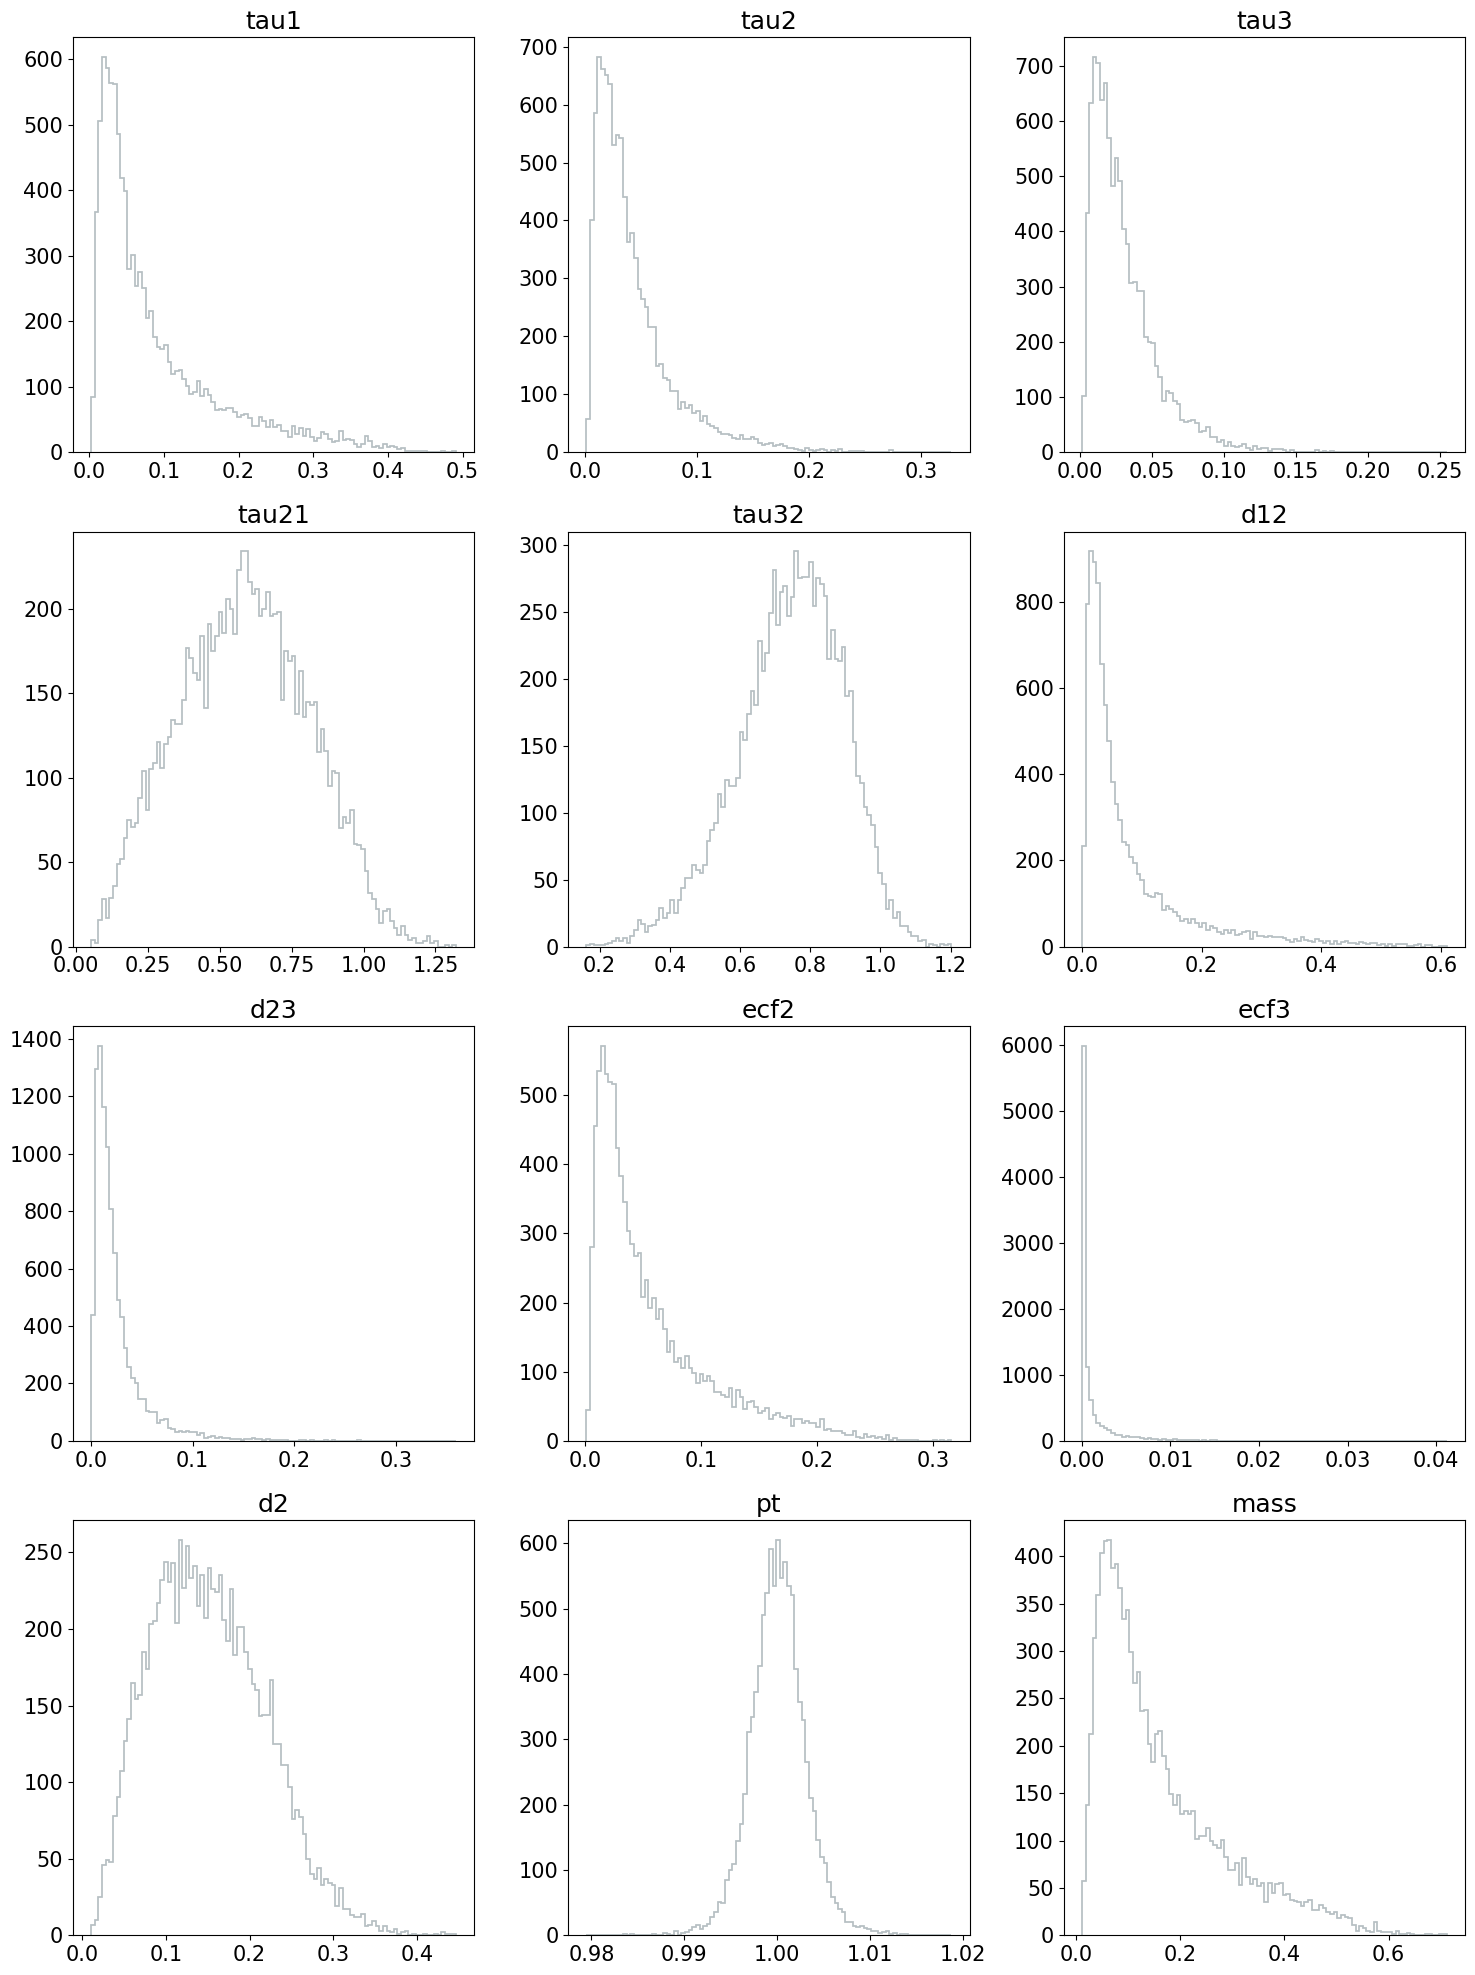

In [17]:
dump_hlvs(
    particle_data_ced.reshape(-1, particle_data_ced.shape[-2], particle_data_ced.shape[-1])[
        :10000
    ],
    "/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_ced",
    plot=True,
)

In [7]:
# load substructure for id data
data_substructure_id = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_id" + ".h5", "r") as f:
    tau21_jetnet = np.array(f["tau21"])
    tau32_jetnet = np.array(f["tau32"])
    d2_jetnet = np.array(f["d2"])
    for key in f.keys():
        data_substructure_id.append(np.array(f[key]))
data_substructure_jetnet = np.array(data_substructure_id)

In [101]:
# load substructure for model generated data
keys = []
data_substructure_v = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_v" + ".h5", "r") as f:
    tau21_v = np.array(f["tau21"])
    tau32_v = np.array(f["tau32"])
    d2_v = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_v.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_v = np.array(data_substructure_v)

In [8]:
# load substructure for model generated data
keys = []
data_substructure_ced = []
with h5py.File("/beegfs/desy/user/ewencedr/data/lhco/substructure/notebook_ced" + ".h5", "r") as f:
    tau21_ced = np.array(f["tau21"])
    tau32_ced = np.array(f["tau32"])
    d2_ced = np.array(f["d2"])
    for key in f.keys():
        keys.append(key)
        data_substructure_ced.append(np.array(f[key]))
keys = np.array(keys)
data_substructure_ced = np.array(data_substructure_ced)

In [97]:
# calculate wasserstein distances
w_dist_tau21_mean, w_dist_tau21_std = wasserstein_distance_batched(
    tau21_jetnet, tau21_jetnet, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean, w_dist_tau32_std = wasserstein_distance_batched(
    tau32_jetnet, tau32_jetnet, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean, w_dist_d2_std = wasserstein_distance_batched(
    d2_jetnet, d2_jetnet, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean} +- {w_dist_tau21_std}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean} +- {w_dist_tau32_std}")
print(f"Wasserstein distance d2: {w_dist_d2_mean} +- {w_dist_d2_std}")

Wasserstein distance tau21: 0.0017980722479258777 +- 0.0005707187698977295
Wasserstein distance tau32: 0.001252037460083865 +- 0.0004550670053313386
Wasserstein distance d2: 0.0004959170892831296 +- 0.00016766797762335595


In [103]:
# calculate wasserstein distances
w_dist_tau21_mean_v, w_dist_tau21_std_v = wasserstein_distance_batched(
    tau21_jetnet, tau21_v, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean_v, w_dist_tau32_std_v = wasserstein_distance_batched(
    tau32_jetnet, tau32_v, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean_v, w_dist_d2_std_v = wasserstein_distance_batched(
    d2_jetnet, d2_v, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean_v} +- {w_dist_tau21_std_v}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean_v} +- {w_dist_tau32_std_v}")
print(f"Wasserstein distance d2: {w_dist_d2_mean_v} +- {w_dist_d2_std_v}")

Wasserstein distance tau21: 0.008501626111957816 +- 0.0013012708590722382
Wasserstein distance tau32: 0.002416620464150449 +- 0.00046271410937133797
Wasserstein distance d2: 0.0009864880189005393 +- 0.00018194432768966478


In [26]:
# calculate wasserstein distances
w_dist_tau21_mean_ced, w_dist_tau21_std_ced = wasserstein_distance_batched(
    tau21_jetnet, tau21_ced, num_eval_samples=50_000, num_batches=40
)
w_dist_tau32_mean_ced, w_dist_tau32_std_ced = wasserstein_distance_batched(
    tau32_jetnet, tau32_ced, num_eval_samples=50_000, num_batches=40
)
w_dist_d2_mean_ced, w_dist_d2_std_ced = wasserstein_distance_batched(
    d2_jetnet, d2_ced, num_eval_samples=50_000, num_batches=40
)
print(f"Wasserstein distance tau21: {w_dist_tau21_mean_ced} +- {w_dist_tau21_std_ced}")
print(f"Wasserstein distance tau32: {w_dist_tau32_mean_ced} +- {w_dist_tau32_std_ced}")
print(f"Wasserstein distance d2: {w_dist_d2_mean_ced} +- {w_dist_d2_std_ced}")

Wasserstein distance tau21: 0.026390812904005866 +- 0.0012934804971217726
Wasserstein distance tau32: 0.009065267897363238 +- 0.0009592811977104869
Wasserstein distance d2: 0.003893564191410836 +- 0.00043295475978376573


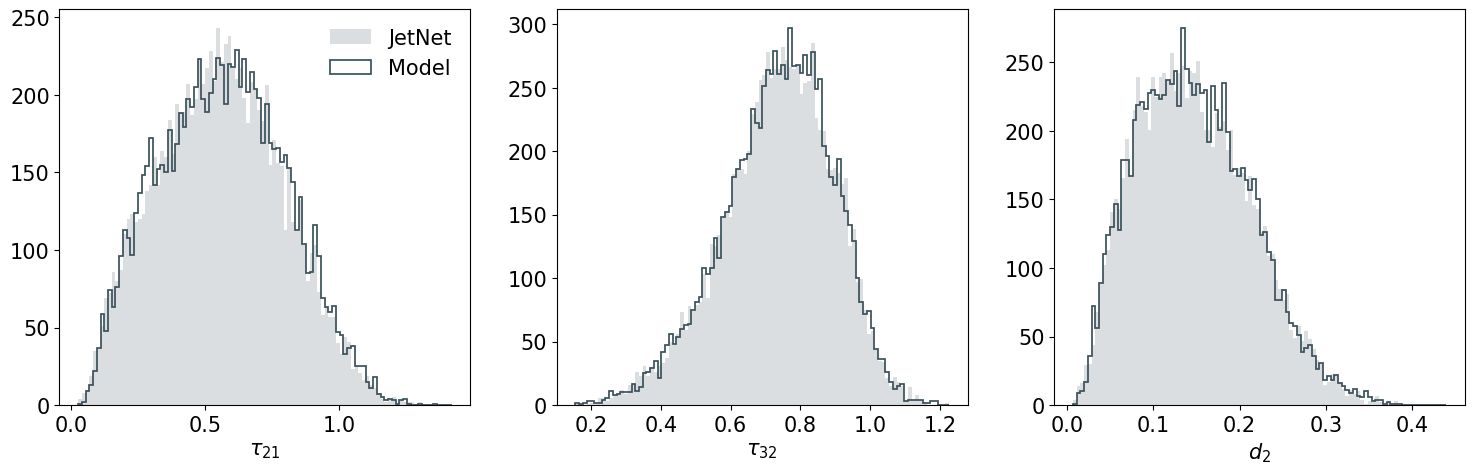

In [106]:
plot_substructure(
    tau21=tau21_v,
    tau32=tau32_v,
    d2=d2_v,
    tau21_jetnet=tau21_jetnet,
    tau32_jetnet=tau32_jetnet,
    d2_jetnet=d2_jetnet,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

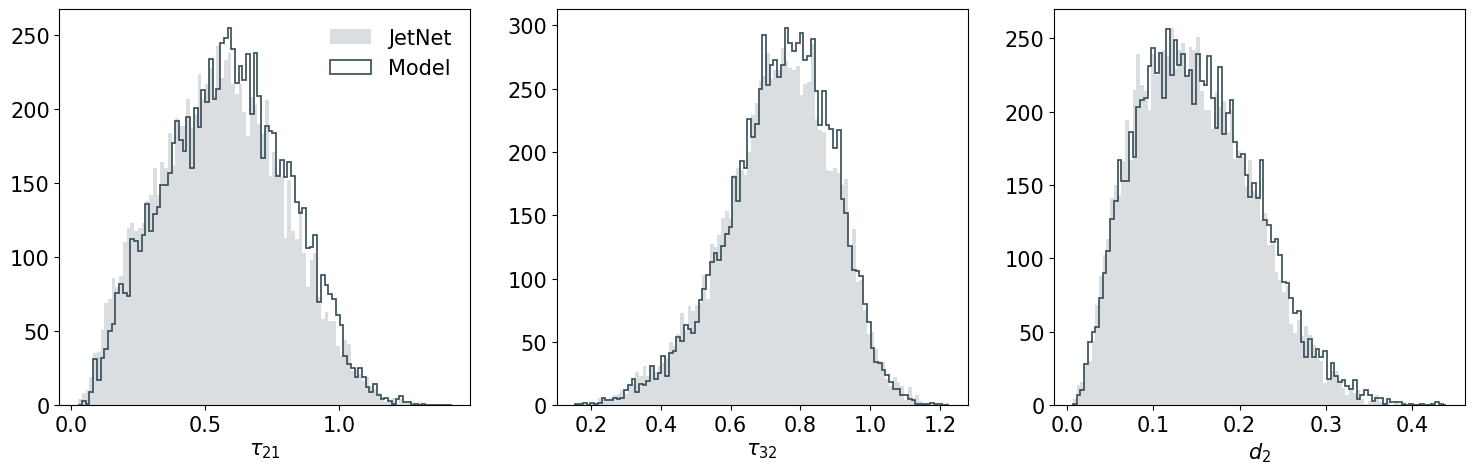

In [9]:
plot_substructure(
    tau21=tau21_ced,
    tau32=tau32_ced,
    d2=d2_ced,
    tau21_jetnet=tau21_jetnet,
    tau32_jetnet=tau32_jetnet,
    d2_jetnet=d2_jetnet,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

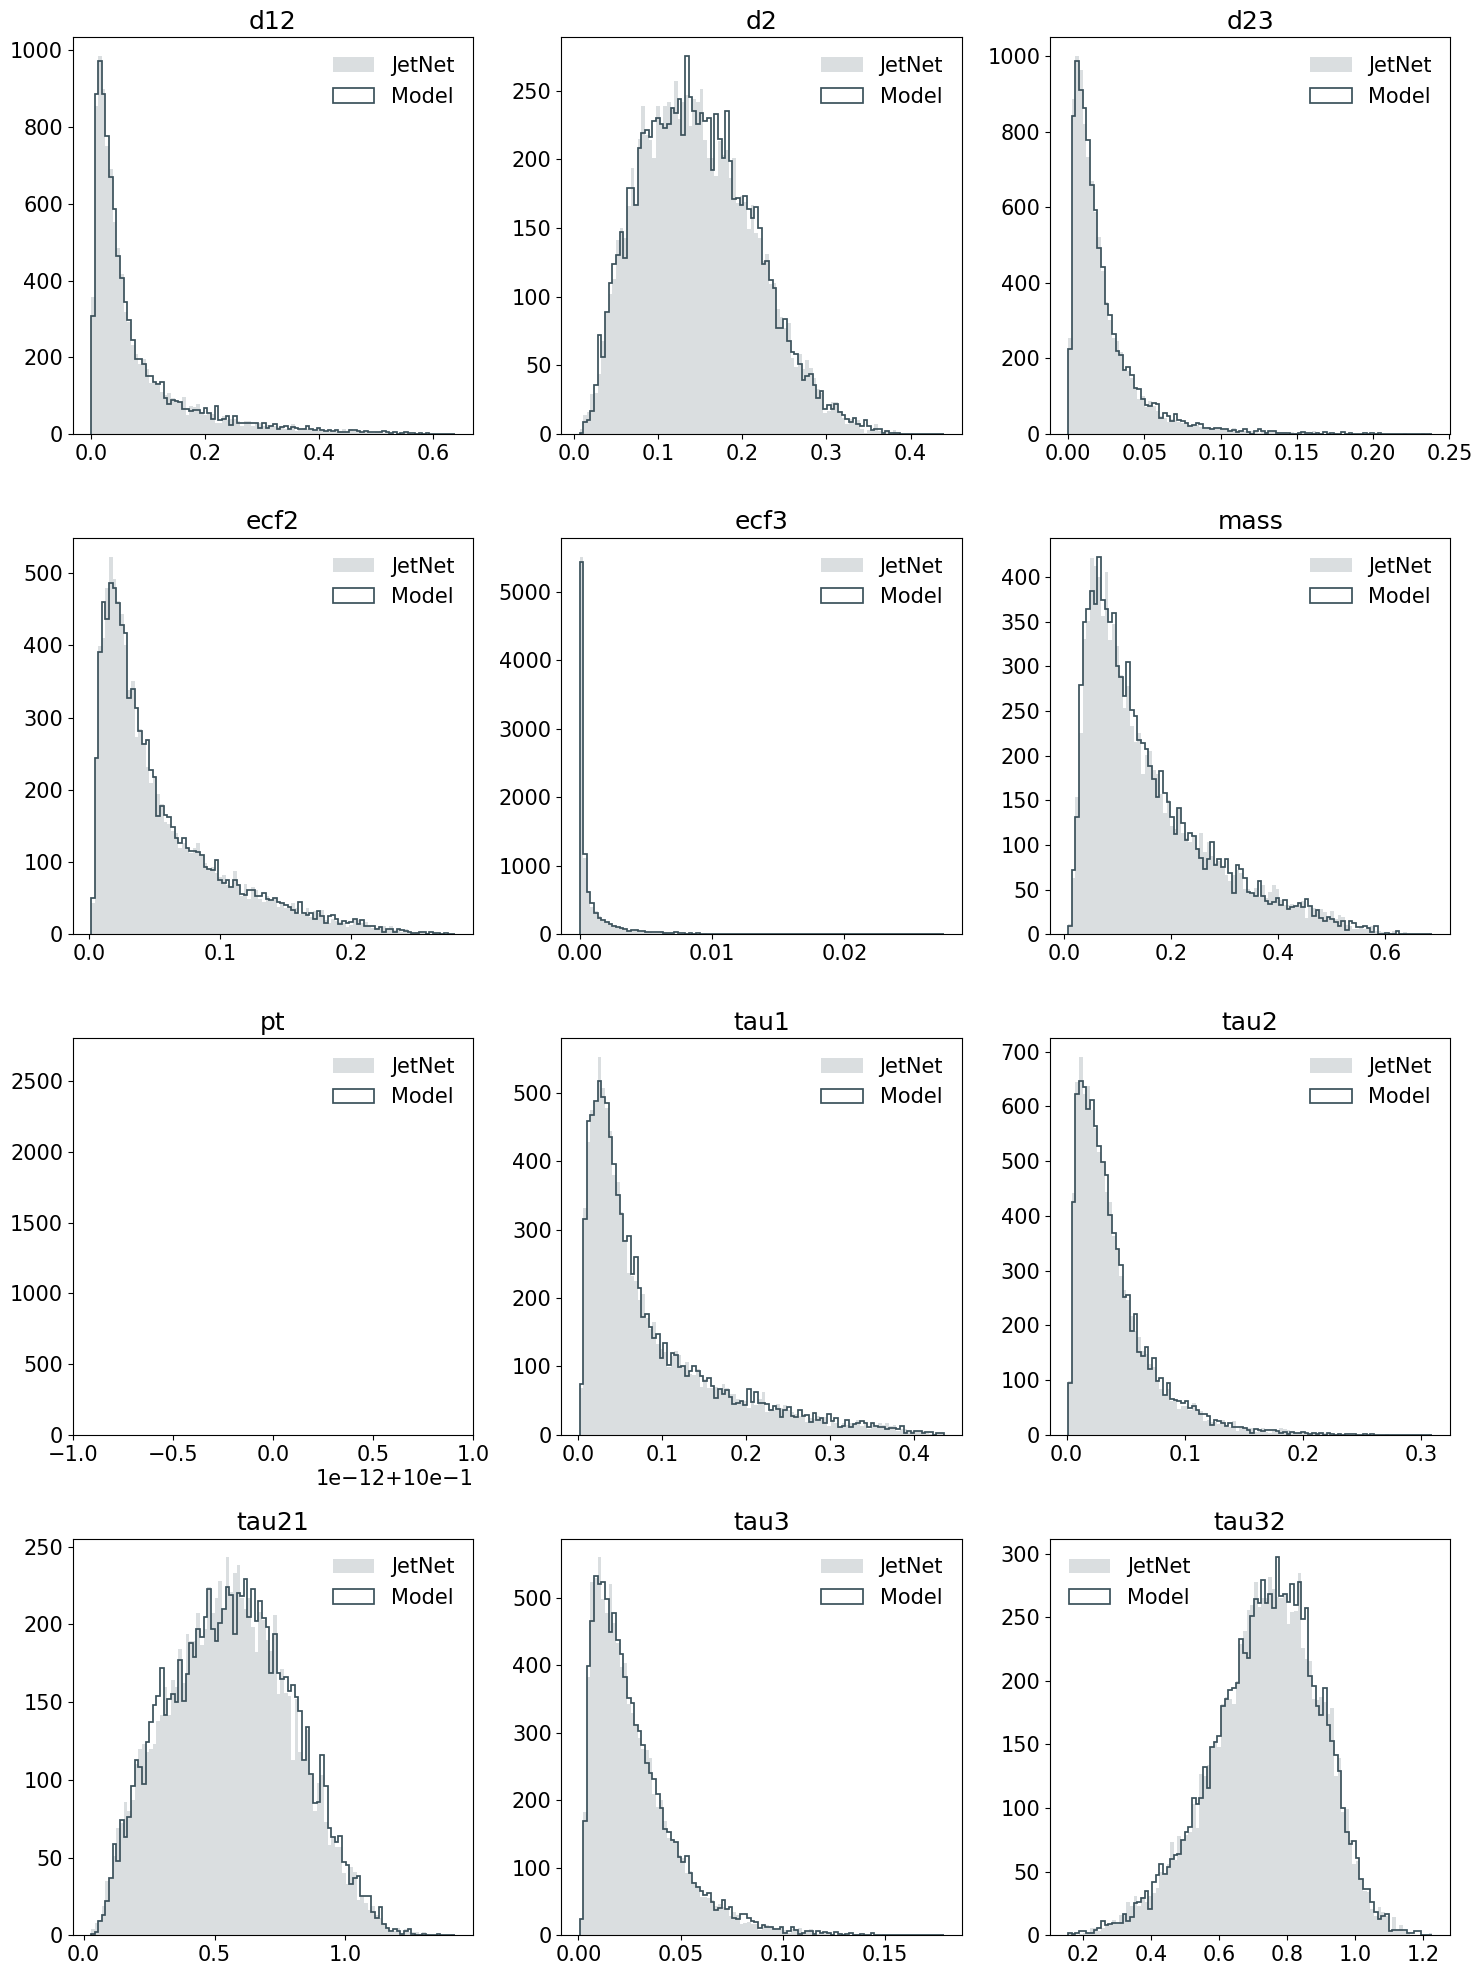

In [108]:
plot_full_substructure(
    data_substructure=data_substructure_v,
    data_substructure_jetnet=data_substructure_jetnet,
    keys=keys,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

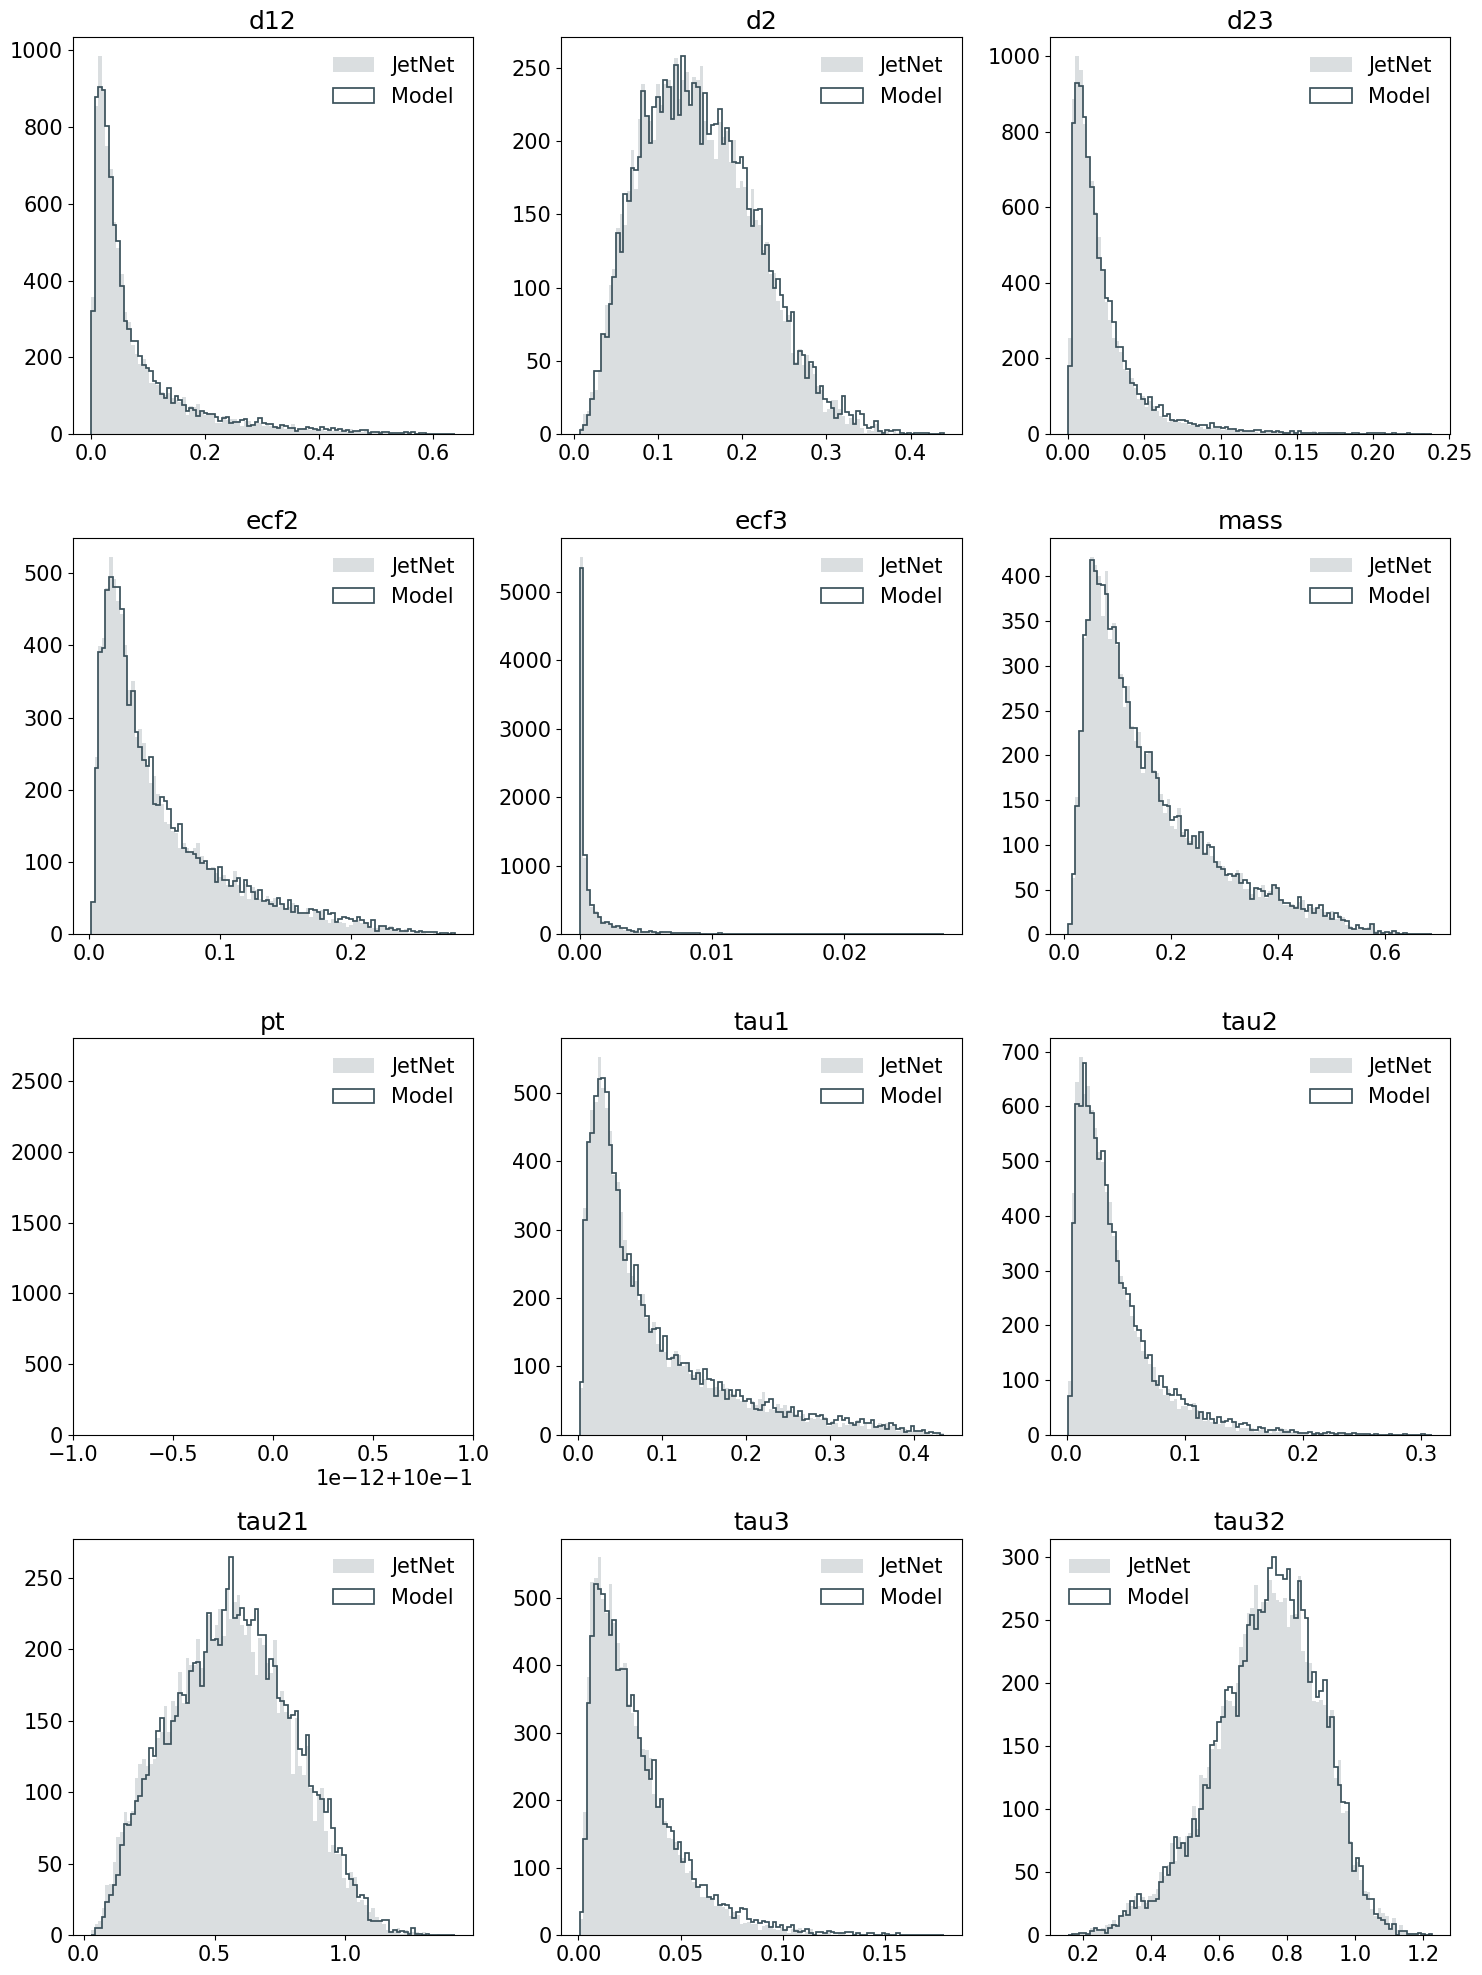

In [109]:
plot_full_substructure(
    data_substructure=data_substructure_ced,
    data_substructure_jetnet=data_substructure_jetnet,
    keys=keys,
    save_fig=False,
    save_folder=None,
    save_name=None,
    close_fig=True,
)

## Compare MJJ